# Import

## Dependencies

In [1]:
import time
import numpy as np
import pandas as pd
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Data

In [2]:
# Load np array
features = np.load('../10_data/features.npy', allow_pickle=True)

bags_train = np.load('../10_data/bags.npy', allow_pickle=True)
id_bags_train = np.load('../10_data/id_bags.npy', allow_pickle=True)
date_bags_train = np.load('../10_data/date_bags.npy', allow_pickle=True)
y_round_up_bag_train = np.load('../10_data/y_round_up_bag.npy', allow_pickle=True).astype('int')
y_ins_train = np.load('../10_data/y_ins.npy', allow_pickle=True)

In [3]:
def print_data_stats(list_x, list_y):
    print('- There are {} bags'.format(len(list_x)))
    print('- There are {} labels with values [{}]'.format(len(list_y), ', '.join([str(i) for i in np.unique(list_y)])))
    
    bags_len = [len(i) for i in list_x]
    print('- Bags length varies between {} and {}'.format(min(bags_len), max(bags_len)))
    
    elem_len = [len(e) for sl in list_x for e in sl]
    print('- Element length varies between {} and {}'.format(min(elem_len), max(elem_len)))

print('Training set:')
print_data_stats(bags_train, y_round_up_bag_train)

Training set:
- There are 13813 bags
- There are 13813 labels with values [0, 1]
- Bags length varies between 1 and 78
- Element length varies between 14 and 14


## Example

In [4]:
def draw_example(df_bags, df_bags_ins, df_bags_y_round_up, df_bag_id, df_bag_date=None):
    bag_idx = np.random.randint(0, len(df_bags))
    print('Selected bag with id {}'.format(bag_idx))
    if df_bag_date is not None:
        print('Selected bag with date {}'.format(df_bag_date[bag_idx]))
    print('{} invoice lines'.format(len(df_bags[bag_idx])))
    
    print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id)
    
    return bag_idx

def print_bag_details(bag_idx, df_bags_ins, df_bags_y_round_up, df_bag_id, search_admin_customer=False):
    print('bag label \'Round up\' = {}'.format(df_bags_y_round_up[bag_idx]))
    print('instance labels = {}'.format(df_bags_ins[bag_idx]))
    print('Invoice nr = {}'.format(df_bag_id[bag_idx]))

    if search_admin_customer:
        from admin import admin_sql
        cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
        print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(df_bag_id[bag_idx]))['CUSTOMER_ID'].iloc[0]))

bag_idx = draw_example(bags_train, y_ins_train, y_round_up_bag_train, id_bags_train, date_bags_train)

Selected bag with id 4401
Selected bag with date [2021 4 17]
12 invoice lines
bag label 'Round up' = 1
instance labels = ['ROUND_DOWN' 'NONE' 'NONE' 'NONE' 'ROUND_UP' 'NONE' 'NONE' 'NONE' 'NONE'
 'NONE' 'NONE' 'ROUND_UP']
Invoice nr = 2106610


In [5]:
y_ins_train[bag_idx]

array(['ROUND_DOWN', 'NONE', 'NONE', 'NONE', 'ROUND_UP', 'NONE', 'NONE',
       'NONE', 'NONE', 'NONE', 'NONE', 'ROUND_UP'], dtype=object)

In [6]:
pd.DataFrame(data=bags_train[bag_idx], columns=features).head()

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,50.442856,1.0,153.0,0.0,82.800003,20.0,0.0,528.0,2163.0,0.0,1.0,0.0,1.0,0.0
1,50.442856,1.0,153.0,0.0,82.800003,5.0,1.0,2167.0,2167.0,0.0,1.0,0.0,1.0,0.0
2,50.442856,0.0,92.0,0.0,83.199997,10.0,0.0,2245.0,145.0,1.0,0.0,0.0,1.0,0.0
3,50.442856,0.0,66.0,24.0,83.199997,20.0,0.0,3175.0,204.0,0.0,1.0,0.0,1.0,0.0
4,50.442856,1.0,66.0,0.0,83.199997,10.0,1.0,104.0,104.0,1.0,0.0,0.0,1.0,0.0


# Limit dataset size

In [7]:
invoice_months = np.array([i[1] for i in date_bags_train])
pd.DataFrame(np.unique(invoice_months, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2,3,4,5,6,7,8,9,10,11,12
1,1078,1073,1105,1457,731,1305,1249,986,1105,1276,1262,1186


In [8]:
invoice_weeks = np.array([i[2] for i in date_bags_train])
pd.DataFrame(np.unique(invoice_weeks, return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,2,4,7,8,10,11,12,13,14,15,16,17,19,21,22,23,24,26,28,29,30,32,33,34,35,37,39,40,41,42,43,46,48,50,51,52
1,6,1072,42,1031,1,41,1,1064,33,35,1,1386,32,1,698,1,163,1141,3,2,1244,14,1,1,970,80,1025,6,108,7,1155,78,1184,28,11,1147


In [9]:
train_month = 1

bags_train_1 = bags_train[invoice_months == train_month]
id_bags_train_1 = id_bags_train[invoice_months == train_month]
y_round_up_bag_train_1 = y_round_up_bag_train[invoice_months == train_month]
y_ins_train_1 = y_ins_train[invoice_months == train_month]

bags_train_2 = bags_train[invoice_months != train_month]
id_bags_train_2 = id_bags_train[invoice_months != train_month]
y_round_up_bag_train_2 = y_round_up_bag_train[invoice_months != train_month]
y_ins_train_2 = y_ins_train[invoice_months != train_month]

invoice_months = invoice_months[invoice_months != train_month]

# Pipeline components

## StandarizerBagsList

In [10]:
from preprocessing.standarize_bags import StandarizerBagsList

bag_standardizer = StandarizerBagsList()

start_time = time.time()
bag_standardizer.fit(bags_train_1)
print("Standardizer fitting time: {:.2f} sec".format(time.time() - start_time))

# Print average and stdev time registration
pd.DataFrame(data=[bag_standardizer.mean, bag_standardizer.std], columns=features)

Standardizer fitting time: 0.02 sec


,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,94.539965,0.0,102.660429,11.760481,88.846846,41.692629,0.0,2037.442760,1859.773968,0.0,0.0,0.0,0.0,0.0
1,44.500064,1.0,73.817756,33.158868,10.582455,69.764743,1.0,1869.067972,1484.354047,1.0,1.0,1.0,1.0,1.0


### Example

In [11]:
bag_idx = draw_example(bags_train_2, y_round_up_bag_train_2, id_bags_train_2, id_bags_train_2)

Selected bag with id 9152
30 invoice lines
bag label 'Round up' = 2204753
instance labels = 1
Invoice nr = 2204753


In [12]:
# Show example bag
pd.DataFrame(data=bags_train_2[bag_idx], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,57.120148,1.0,73.0,35.0,83.199997,35.0,1.0,1127.0,1127.0,0.0,1.0,0.0,1.0,0.0
1,57.120148,1.0,118.0,49.0,83.199997,135.0,1.0,1109.0,1109.0,0.0,0.0,0.0,1.0,0.0
2,57.120148,1.0,103.0,29.0,83.199997,15.0,0.0,2064.0,966.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Transfrom one bag
pd.DataFrame(data=bag_standardizer.transform([bags_train_2[bag_idx]])[0], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,-0.840894,1.0,-0.401806,0.700854,-0.533605,-0.095931,1.0,-0.487111,-0.493665,0.0,1.0,0.0,1.0,0.0
1,-0.840894,1.0,0.207803,1.123064,-0.533605,1.337457,1.0,-0.496741,-0.505792,0.0,0.0,0.0,1.0,0.0
2,-0.840894,1.0,0.004600,0.519907,-0.533605,-0.382609,0.0,0.014209,-0.602130,0.0,0.0,0.0,1.0,0.0


### Standardize data set

In [14]:
start_time = time.time()
bags_train_1_std = bag_standardizer.transform(bags_train_1)
print("Standardizer transform time (train set): {:.2f} sec".format(time.time() - start_time))

start_time = time.time()
bags_train_2_std = bag_standardizer.transform(bags_train_2)
print("Standardizer transform time (validation set): {:.2f} sec".format(time.time() - start_time))

Standardizer transform time (train set): 0.02 sec
Standardizer transform time (validation set): 0.28 sec


## MILESMapping

In [15]:
from bag_representation.miles_mapping import *

bag_miles_mapping = MILESMapping(sigma2=4.5**2, return_iip_bag_closest=True)


start_time = time.time()
bag_miles_mapping.fit(bags_train_1_std)
print("MILES Mapping fitting time: {:.2f} sec".format(time.time() - start_time))

MILES Mapping fitting time: 0.00 sec


### Example

In [16]:
bag_idx = draw_example(bags_train_2_std, y_round_up_bag_train_2, id_bags_train_2, id_bags_train_2)

Selected bag with id 11700
9 invoice lines
bag label 'Round up' = 2207625
instance labels = 1
Invoice nr = 2207625


In [17]:
# Show example bag
pd.DataFrame(data=bags_train_2_std[bag_idx], columns=features).head(3)

,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,-0.21422,1.0,0.614210,0.369118,1.857145,-0.167601,0.0,-0.788865,0.484538,0.0,0.0,0.0,1.0,0.0
1,-0.21422,1.0,0.343272,-0.354671,-0.533605,2.269160,1.0,0.299913,0.497338,0.0,1.0,0.0,1.0,0.0
2,-0.21422,1.0,-0.388259,-0.354671,-0.533605,-0.382609,1.0,0.294027,0.489928,0.0,0.0,0.0,1.0,0.0


In [18]:
# Transfrom one bag
test, test_closest = bag_miles_mapping.transform([bags_train_2_std[bag_idx]])
test, test_closest = test[0], test_closest[0] 
print('length = {}; max = {:.2f}; min = {:.2f}'.format(len(test), test.max(), test.min()))
test

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.01it/s]

length = 9565; max = 1.00; min = 0.00


array([0.78981583, 0.74127311, 0.71854669, ..., 0.72036464, 0.87303232,
       0.83541776])

In [19]:
from utils.utils import bags2instances

# Intermediary instance pool
iip = bags2instances(bags_train_1)

# Show similar lines from iip compared with example bag
print('{} lines in iip are similar to one of the lines of this bag.'.format(len(np.where(test > .999)[0])))
pd.DataFrame(data=iip[np.where(test > .999)], columns=features).head(50)

2 lines in iip are similar to one of the lines of this bag.


,INVOICE_RATE_HOUR,REG_OBJECT_INVOICED,REMARK_LENGTH,INTERNAL_REMARK_LENGTH,LINE_TARIFF,LINE_ORIGINAL_QUANTITY,F_PRESTATION_BY_PM,F_COLLEAGUE_EXP_DAYS,F_PM_EXP_DAYS,F_DISTANCE_5_MIN,F_DISTANCE_10_MIN,F_DIFF_SELL_TO_CUST,PROJECT_TYPE_DESCRIPTION_Dossier Compta,PROJECT_TYPE_DESCRIPTION_Dossier Social
0,83.199997,1.0,74.0,0.0,83.199997,15.0,1.0,2502.0,2502.0,0.0,0.0,0.0,1.0,0.0
1,83.199997,1.0,73.0,0.0,83.199997,5.0,1.0,2493.0,2493.0,0.0,1.0,0.0,1.0,0.0


### Apply MILES Mapping on data set

In [20]:
bags_train_std_miles, bags_train_std_miles_closest = bag_miles_mapping.transform(bags_train_1_std)

bags_validation_std_miles, bags_validation_std_miles_closest = bag_miles_mapping.transform(bags_train_2_std)

100%|████████████████████████████████████████████████████████████████████████████| 12735/12735 [04:12<00:00, 50.34it/s]


## Model: Random forest

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

def model_evaluation(y, y_predicted, min_recall=.95, prob_col=1):
    y_predicted = np.array([float(i) for i in y_predicted.iloc[:, prob_col]])
    
    #Get ROC values for entire validation set
    fpr, tpr, _ = roc_curve(y_true=y, y_score=y_predicted)
    print("AUC = {}".format(roc_auc_score(y, y_predicted)))
    
    # Get Precision/Recall
    precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=y_predicted)
    thresholds = [0] + thresholds.tolist()
    min_recall_threshold = thresholds[np.abs(recall - min_recall).argmin()]
    
    # Calulate specificity at this rate
    tn, fp, fn, tp = confusion_matrix(y, y_predicted>min_recall_threshold).ravel()
    specificity = (tn / (tn+fp))*100
    
    print('Recall of {:.2f} % reached on {:.3f} threshold. This equals a {:.3f} % specificity'.format(min_recall*100, min_recall_threshold, specificity))
    
    # Create figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
    
    # Figure 1 - ROC
    axs[0].plot(fpr, tpr, lw=1, color='black')
    axs[0].plot([0, 1], [0, 1], color='black', linestyle='dashed')
    axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 2 - Precision/Recall
    axs[1].plot(recall, precision, lw=1, color='black')
    axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 3 - Precision/Recall
    axs[2].plot(thresholds, precision, label='precision', lw=1, color='black', ls='dotted')
    axs[2].plot(thresholds, recall, label='recall', lw=1, color='black', ls='dashed')
    axs[2].axhline(min_recall, lw=1, color='red')
    axs[2].axvline(min_recall_threshold, ls='--', lw=1, color='black')
    axs[2].legend()
    axs[2].set(xlabel='Threshold', ylabel='Recall/Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    return min_recall_threshold, specificity, roc_auc_score(y, y_predicted)

### Fit RF Model

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=800, max_depth=10, random_state=None, bootstrap=True, n_jobs=-1)

start_time = time.time()
rf.fit(X=bags_train_std_miles, y=y_round_up_bag_train_1)
print("RandomForest fitting time: {:.2f} sec".format(time.time() - start_time))

RandomForest fitting time: 6.17 sec


### Evaluate Validation set

In [23]:
start_time = time.time()
y_bag_validation_pred = pd.DataFrame(rf.predict_proba(bags_validation_std_miles))
print("RandomForest prediction time (validation set): {:.2f} sec".format(time.time() - start_time))

RandomForest prediction time (validation set): 0.97 sec


AUC = 0.73063813387015
Recall of 95.00 % reached on 0.372 threshold. This equals a 23.759 % precision


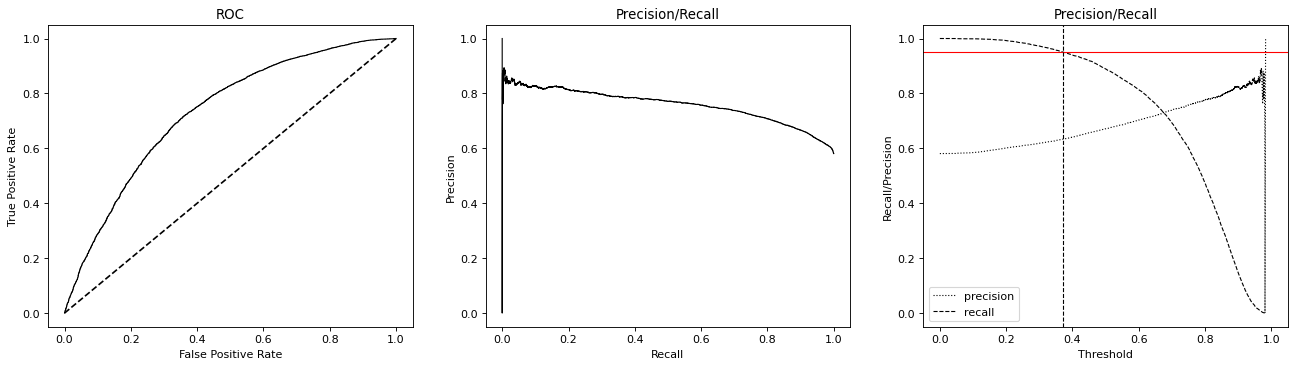

In [24]:
min_threshold, specificity, auc = model_evaluation(y_round_up_bag_train_2, y_bag_validation_pred)

In [25]:
pd.DataFrame(confusion_matrix(y_round_up_bag_train_2, y_bag_validation_pred.iloc[:, 1]>min_threshold), columns=['PRED_FALSE', 'PRED_TRUE'], index=['ACTUAL_FALSE', 'ACTUAL_TRUE'])

,PRED_FALSE,PRED_TRUE
ACTUAL_FALSE,1268,4069
ACTUAL_TRUE,370,7028


## modAL implementation: Uncertainty Sampling

In [207]:
# Previous Month
specificity_benchmark = [0.23699421965317918, 0.2398921832884097, 0.27605633802816903, 0.38522427440633245, 0.31610044313146235, 0.3185840707964602, 0.376940133037694, 0.36694677871148457, 0.32860520094562645, 0.35827664399092973, 0.4369369369369369]
auc_benchmark = [0.7086263503126673, 0.7603575284414316, 0.7166412127382771, 0.7932470316622691, 0.7516887918787457, 0.7560989494384931, 0.8203369459353047, 0.8089096601207328, 0.792524783894418, 0.7773911026042573, 0.8126957820354047]

# Wihtin Month
#specificity_benchmark = [0.3939393939393939, 0.22448979591836735, 0.34210526315789475, 0.2602739726027397, 0.5142857142857142, 0.35526315789473684, 0.3829787234042553, 0.37777777777777777, 0.5862068965517241, 0.4166666666666667, 0.47619047619047616]
#auc_benchmark = [0.8113131313131313, 0.7115185057073676, 0.7768565248738284, 0.7256520923250139, 0.8644688644688644, 0.7772727272727272, 0.7992362247681397, 0.8135802469135802, 0.8292682926829269, 0.8336352657004832, 0.8302521008403362]

In [161]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# Fit model
al_uncertainty = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=800, max_depth=10, random_state=None, bootstrap=True, n_jobs=-1),
    query_strategy=uncertainty_sampling,
    X_training=bags_train_std_miles, y_training=y_round_up_bag_train_1
)

In [162]:
y_bag_validation_pred = pd.DataFrame(al_uncertainty.predict_proba(bags_validation_std_miles))

AUC = 0.7308636352653537
Recall of 95.00 % reached on 0.372 threshold. This equals a 23.253 % precision


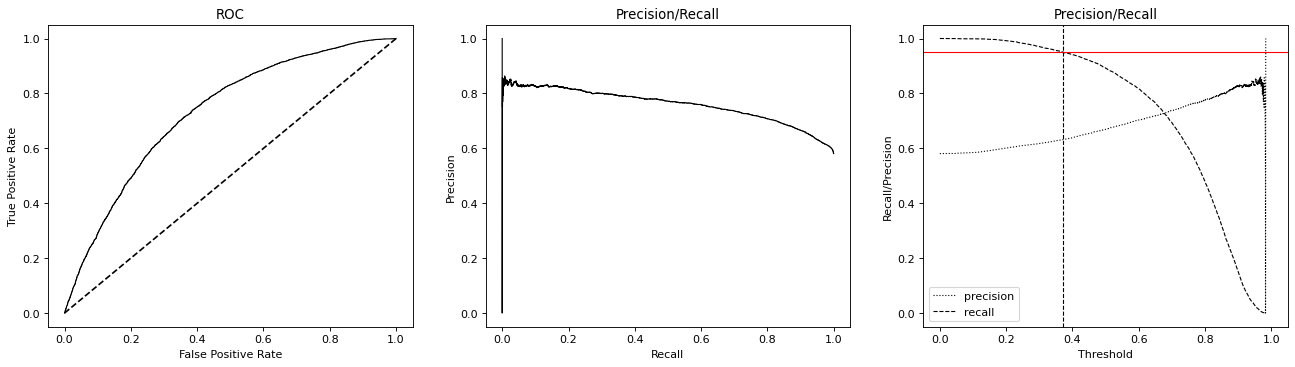

In [163]:
min_threshold, specificity, auc = model_evaluation(y_round_up_bag_train_2, y_bag_validation_pred)

### Active Learning loop

  9%|███████▌                                                                           | 1/11 [00:08<01:23,  8.40s/it]

AUC = 0.7191516709511567
Recall of 95.00 % reached on 0.459 threshold. This equals a 30.591 % precision


 18%|███████████████                                                                    | 2/11 [00:18<01:23,  9.27s/it]

AUC = 0.7524719447643864
Recall of 95.00 % reached on 0.593 threshold. This equals a 32.271 % precision


 27%|██████████████████████▋                                                            | 3/11 [00:30<01:26, 10.77s/it]

AUC = 0.6992437411782186
Recall of 95.00 % reached on 0.558 threshold. This equals a 37.524 % precision


 36%|██████████████████████████████▏                                                    | 4/11 [00:44<01:23, 11.86s/it]

AUC = 0.7767624633431085
Recall of 95.00 % reached on 0.323 threshold. This equals a 43.226 % precision


 45%|█████████████████████████████████████▋                                             | 5/11 [01:00<01:19, 13.33s/it]

AUC = 0.723518831216504
Recall of 95.00 % reached on 0.357 threshold. This equals a 42.218 % precision


 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:18<01:15, 15.03s/it]

AUC = 0.7872181120590569
Recall of 95.00 % reached on 0.353 threshold. This equals a 39.462 % precision


 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:39<01:07, 16.79s/it]

AUC = 0.861569416498994
Recall of 95.00 % reached on 0.358 threshold. This equals a 53.803 % precision


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [02:01<00:55, 18.55s/it]

AUC = 0.831144947007016
Recall of 95.00 % reached on 0.360 threshold. This equals a 45.818 % precision


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:25<00:40, 20.43s/it]

AUC = 0.8457649786019972
Recall of 95.00 % reached on 0.347 threshold. This equals a 41.875 % precision


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:53<00:22, 22.54s/it]

AUC = 0.845103372028745
Recall of 95.00 % reached on 0.397 threshold. This equals a 53.433 % precision


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:22<00:00, 18.41s/it]

AUC = 0.8284201363702308
Recall of 95.00 % reached on 0.415 threshold. This equals a 50.442 % precision


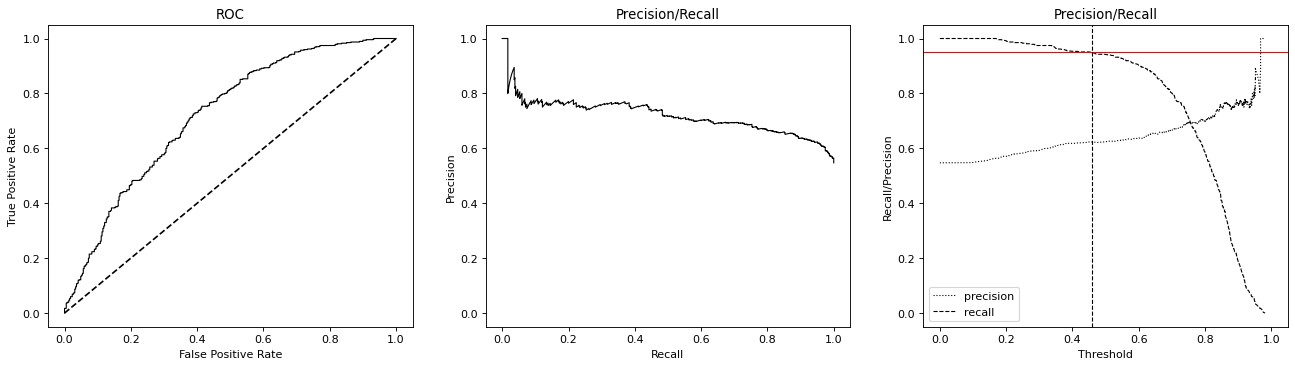

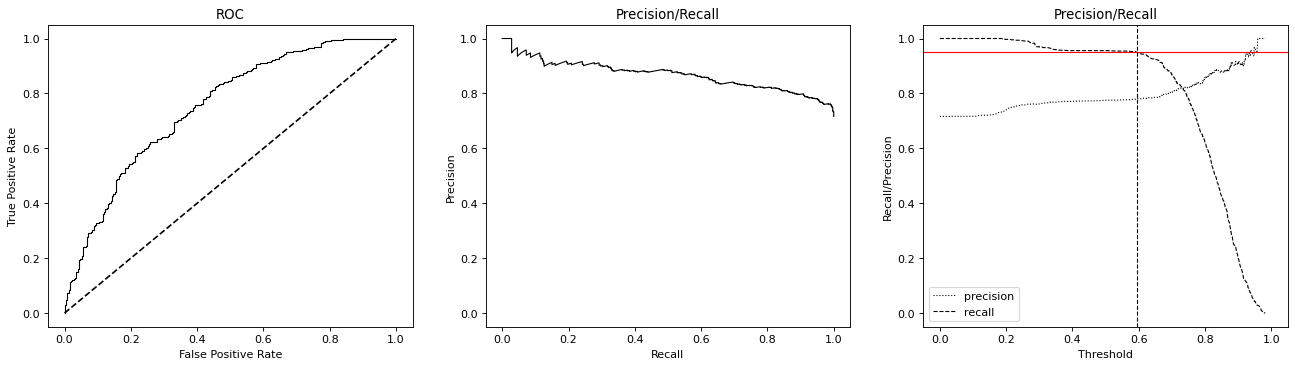

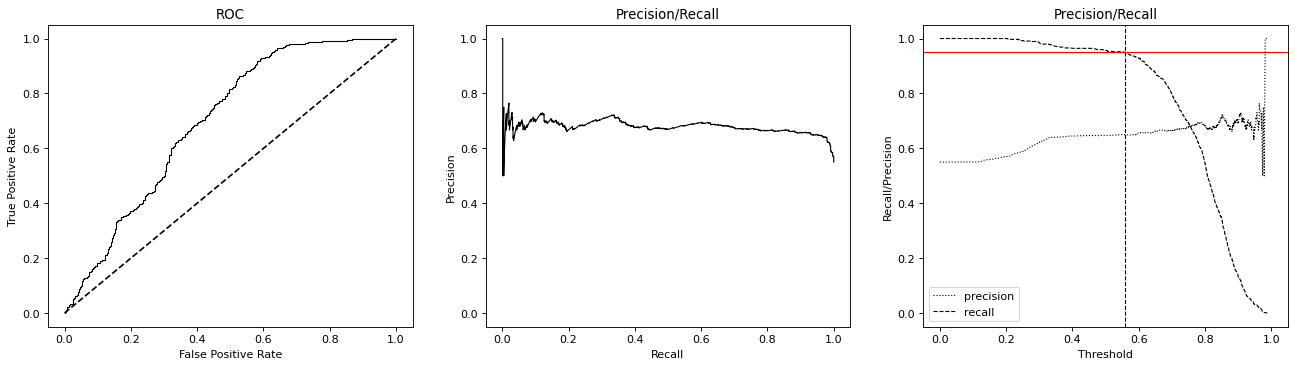

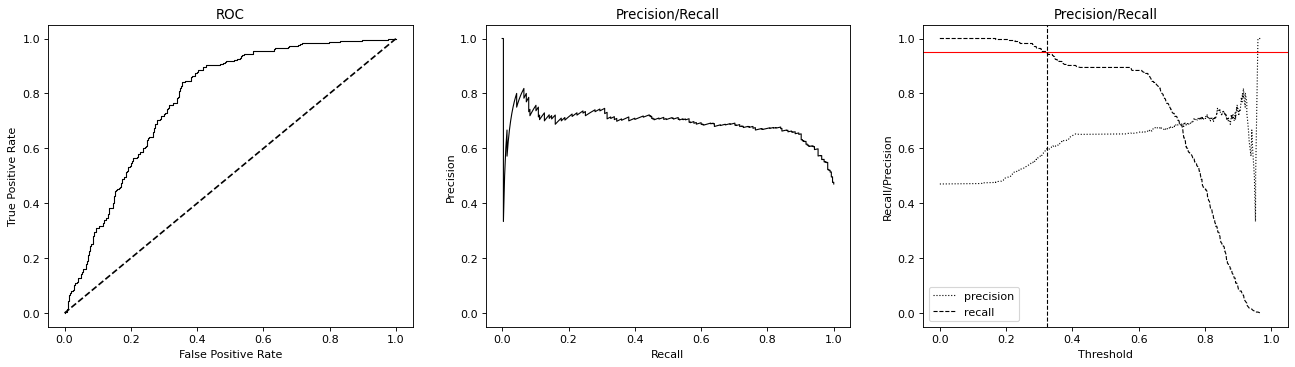

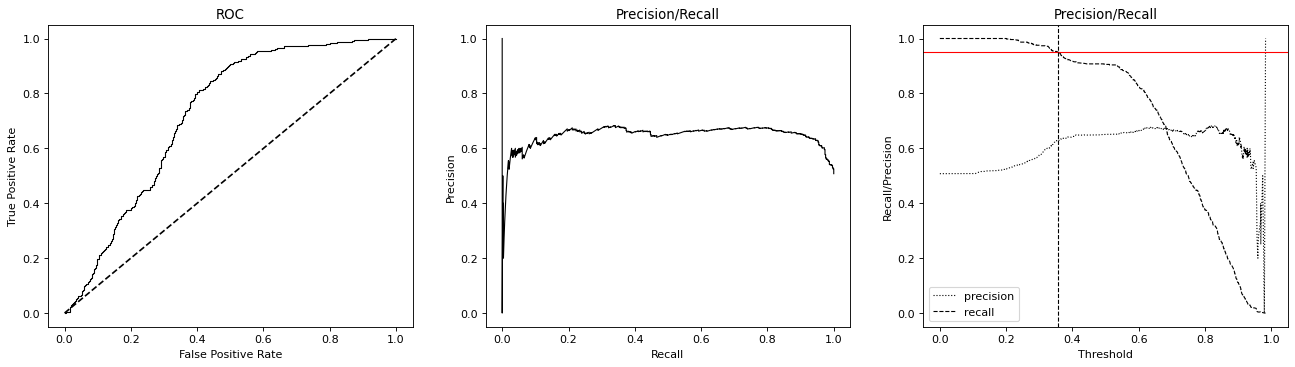

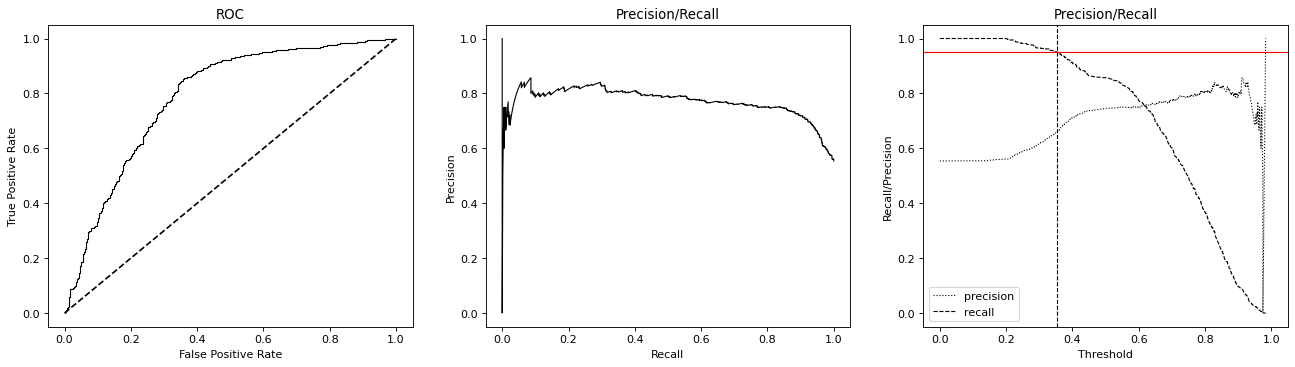

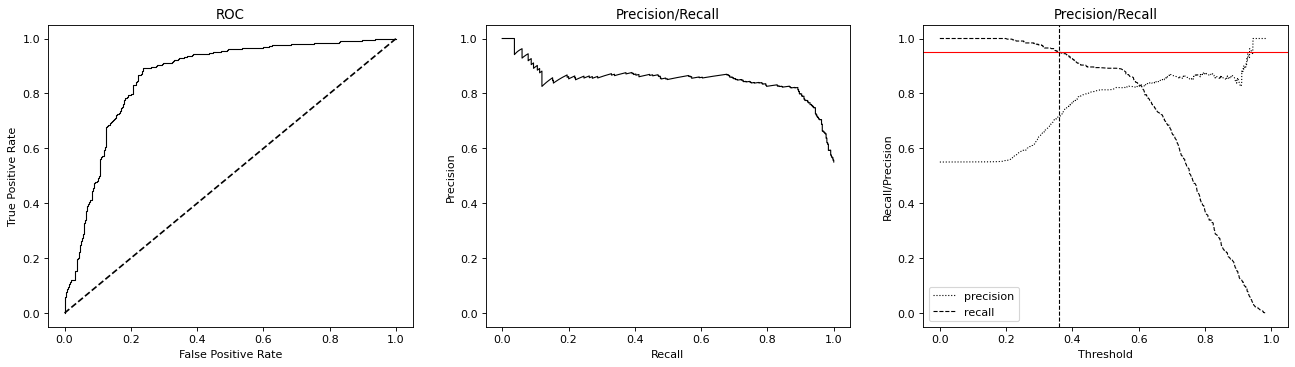

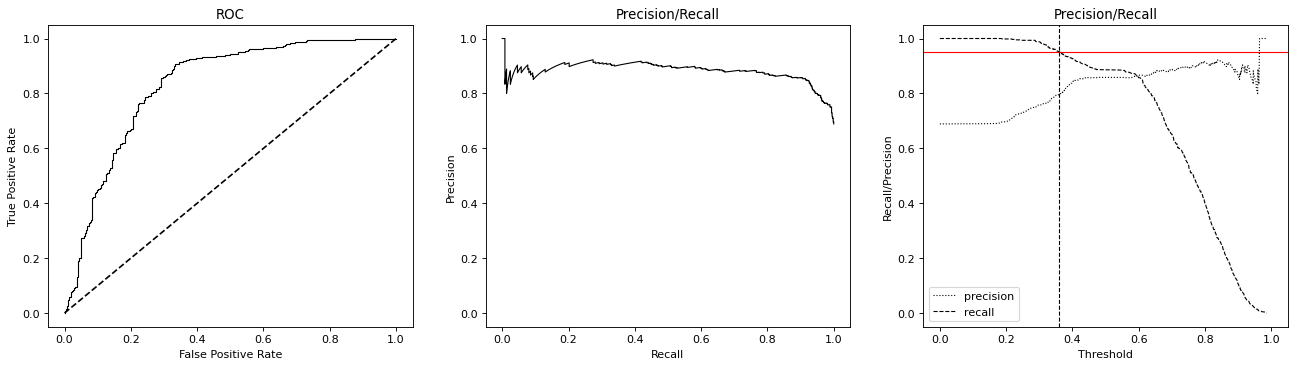

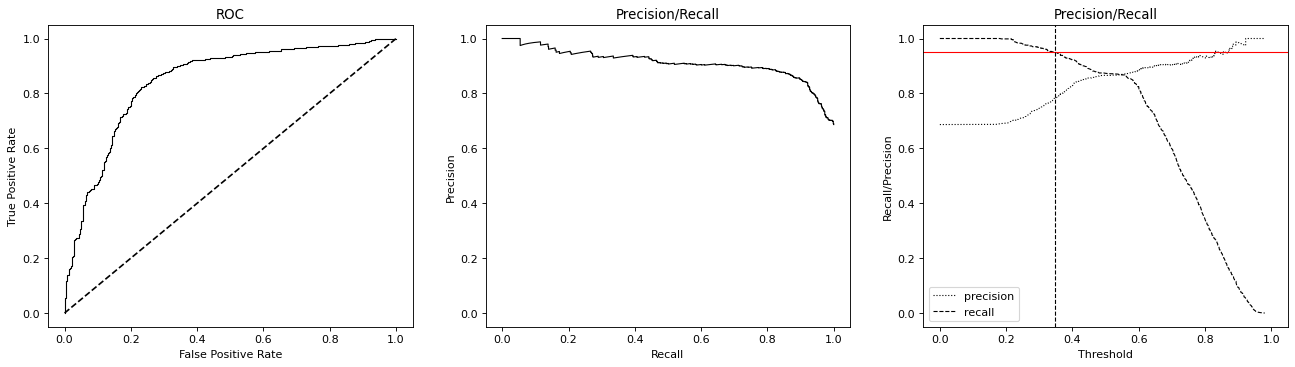

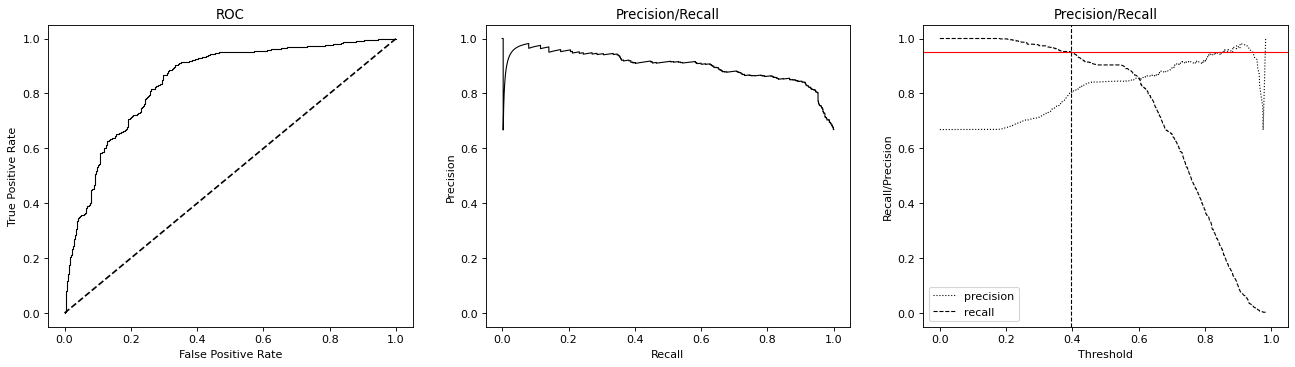

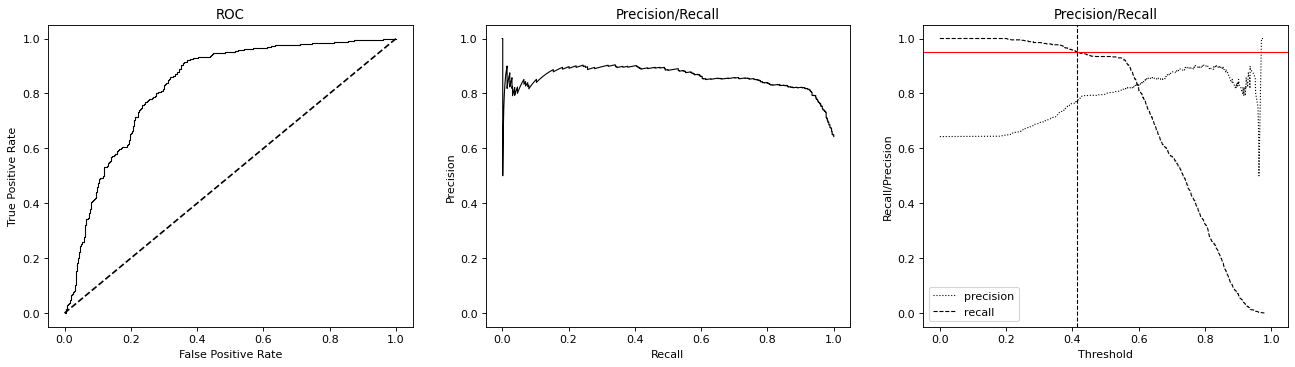

In [164]:
months = [i for i in range(2,12+1)]
queried_invoice_per_month = 0.20

performance_hist_uncertainty = []

for month in tqdm(months):
    
    month_data = bags_validation_std_miles[invoice_months == month]
    month_labels = y_round_up_bag_train_2[invoice_months == month]
    
    most_valuable_instances_idx, most_valuable_instances_data = al_uncertainty.query(month_data, n_instances=int(len(month_data)*queried_invoice_per_month))
    teached_idx = most_valuable_instances_idx.tolist()
    
    al_uncertainty.teach(most_valuable_instances_data, month_labels[most_valuable_instances_idx])
    
    # Predict on validation set
    y_bag_validation_pred = pd.DataFrame(al_uncertainty.predict_proba(np.delete(month_data, teached_idx, axis=0)))
    # Evaluate prediction
    min_threshold, specificity, auc = model_evaluation(np.delete(month_labels, teached_idx, axis=0), y_bag_validation_pred)

    performance_hist_uncertainty += [[min_threshold, specificity, auc]]

In [165]:
performance_hist_uncertainty_20 = performance_hist_uncertainty

In [ ]:
raise(Exception('Stop'))

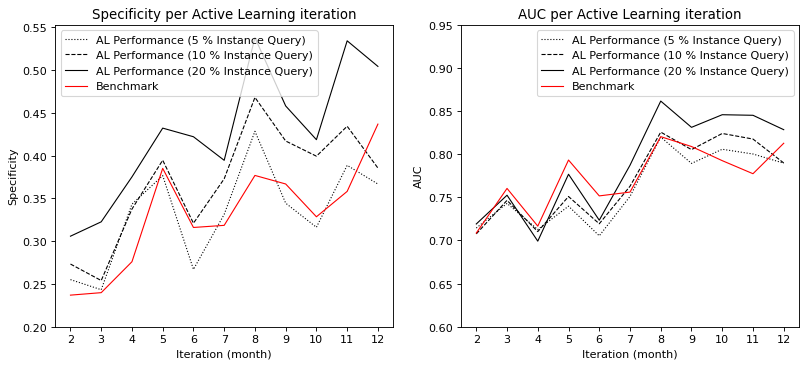

In [203]:
auc_evolution_uncertainty_5 = [i[2] for i in performance_hist_uncertainty_5]
auc_evolution_uncertainty_10 = [i[2] for i in performance_hist_uncertainty_10]
auc_evolution_uncertainty_20 = [i[2] for i in performance_hist_uncertainty_20]
specificity_evolution_uncertainty_5 = [i[1]/100 for i in performance_hist_uncertainty_5]
specificity_evolution_uncertainty_10 = [i[1]/100 for i in performance_hist_uncertainty_10]
specificity_evolution_uncertainty_20 = [i[1]/100 for i in performance_hist_uncertainty_20]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

axs[0].plot(np.arange(2, 13, 1), specificity_evolution_uncertainty_5, lw=1, color='black', ls='dotted', label='AL Performance (5 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_evolution_uncertainty_10, lw=1, color='black', ls='dashed', label='AL Performance (10 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_evolution_uncertainty_20, lw=1, color='black', ls='solid', label='AL Performance (20 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_benchmark, lw=1, color='red', label='Benchmark')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[0].legend()

axs[1].plot(np.arange(2, 13, 1), auc_evolution_uncertainty_5, lw=1, color='black', ls='dotted', label='AL Performance (5 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_evolution_uncertainty_10, lw=1, color='black', ls='dashed', label='AL Performance (10 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_evolution_uncertainty_20, lw=1, color='black', ls='solid', label='AL Performance (20 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_benchmark, lw=1, color='red', label='Benchmark')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration', yticks=np.arange(.6, 1, .05), xticks=np.arange(2, 13, 1))
axs[1].legend()

## modAL implementation: Query by Committee

In [198]:
from modAL.models import ActiveLearner, Committee

X_pool = bags_train_std_miles
y_pool = y_round_up_bag_train_1

# initializing Committee members
n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 500
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=800, max_depth=10, random_state=None, bootstrap=True, n_jobs=-1),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

AUC = 0.7217980916708571
Recall of 95.00 % reached on 0.386 threshold. This equals a 23.571 % precision


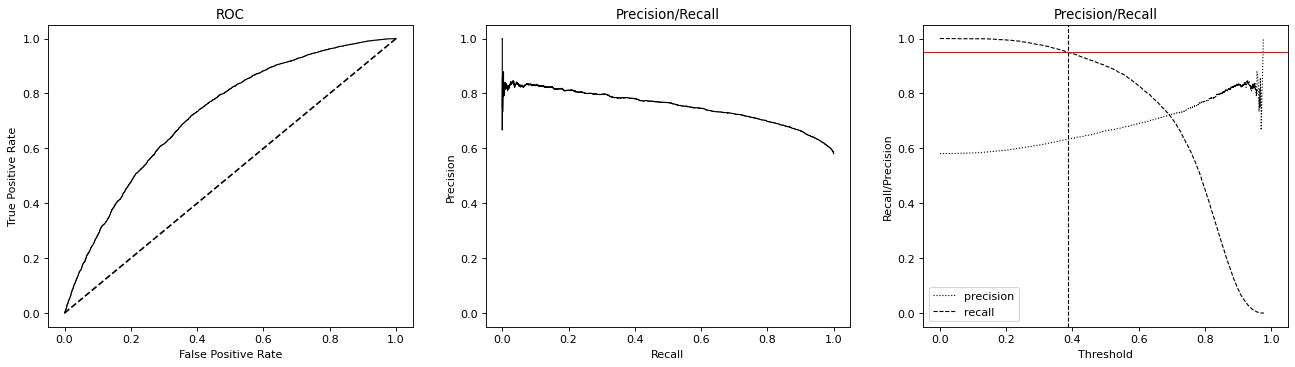

In [199]:
y_bag_validation_pred = pd.DataFrame(committee.predict_proba(bags_validation_std_miles))

min_threshold, specificity, auc = model_evaluation(y_round_up_bag_train_2, y_bag_validation_pred)

### Active Learning loop

  9%|███████▌                                                                           | 1/11 [00:08<01:27,  8.77s/it]

AUC = 0.7097193547393073
Recall of 95.00 % reached on 0.460 threshold. This equals a 23.566 % precision


 18%|███████████████                                                                    | 2/11 [00:18<01:23,  9.27s/it]

AUC = 0.7490318130443454
Recall of 95.00 % reached on 0.440 threshold. This equals a 21.893 % precision


 27%|██████████████████████▋                                                            | 3/11 [00:33<01:35, 11.95s/it]

AUC = 0.7042058047714
Recall of 95.00 % reached on 0.432 threshold. This equals a 30.501 % precision


 36%|██████████████████████████████▏                                                    | 4/11 [00:46<01:27, 12.43s/it]

AUC = 0.7382756162657692
Recall of 95.00 % reached on 0.302 threshold. This equals a 33.799 % precision


 45%|█████████████████████████████████████▋                                             | 5/11 [00:58<01:13, 12.19s/it]

AUC = 0.7062578125000001
Recall of 95.00 % reached on 0.323 threshold. This equals a 28.594 % precision


 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:14<01:07, 13.52s/it]

AUC = 0.7471269313963428
Recall of 95.00 % reached on 0.329 threshold. This equals a 33.021 % precision


 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:27<00:53, 13.38s/it]

AUC = 0.8206315518682873
Recall of 95.00 % reached on 0.322 threshold. This equals a 39.906 % precision


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:41<00:40, 13.53s/it]

AUC = 0.8013372015472855
Recall of 95.00 % reached on 0.319 threshold. This equals a 37.798 % precision


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [02:01<00:31, 15.70s/it]

AUC = 0.8064544895448955
Recall of 95.00 % reached on 0.278 threshold. This equals a 30.000 % precision


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:17<00:15, 15.68s/it]

AUC = 0.8037688193955563
Recall of 95.00 % reached on 0.334 threshold. This equals a 38.443 % precision


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:34<00:00, 14.06s/it]

AUC = 0.795099131962036
Recall of 95.00 % reached on 0.356 threshold. This equals a 40.288 % precision


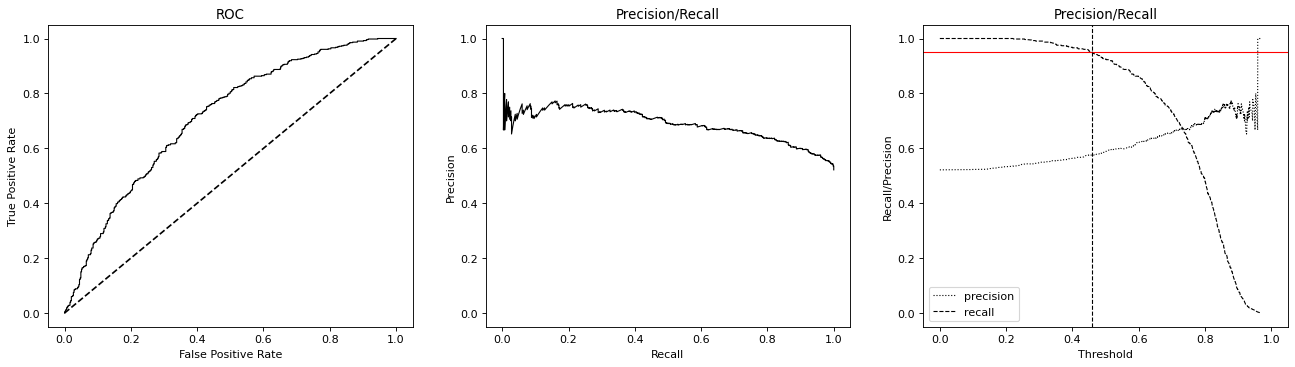

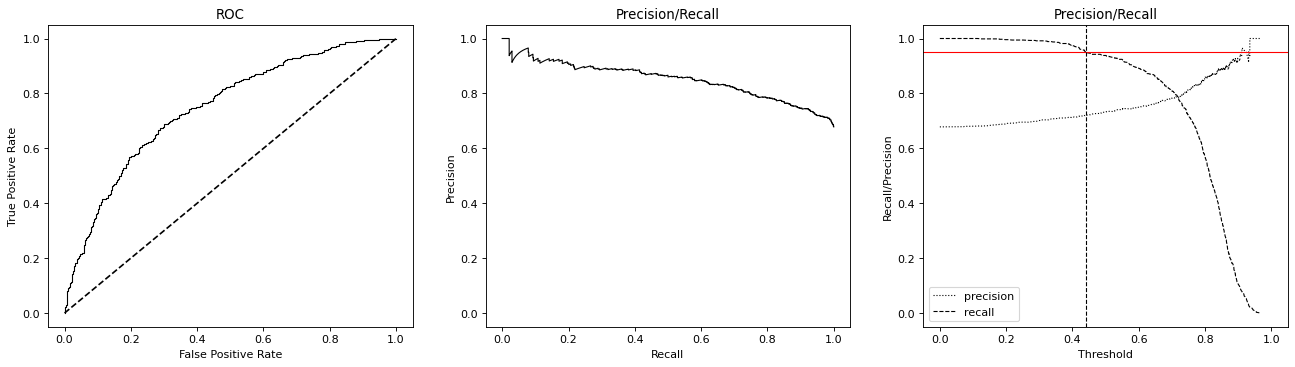

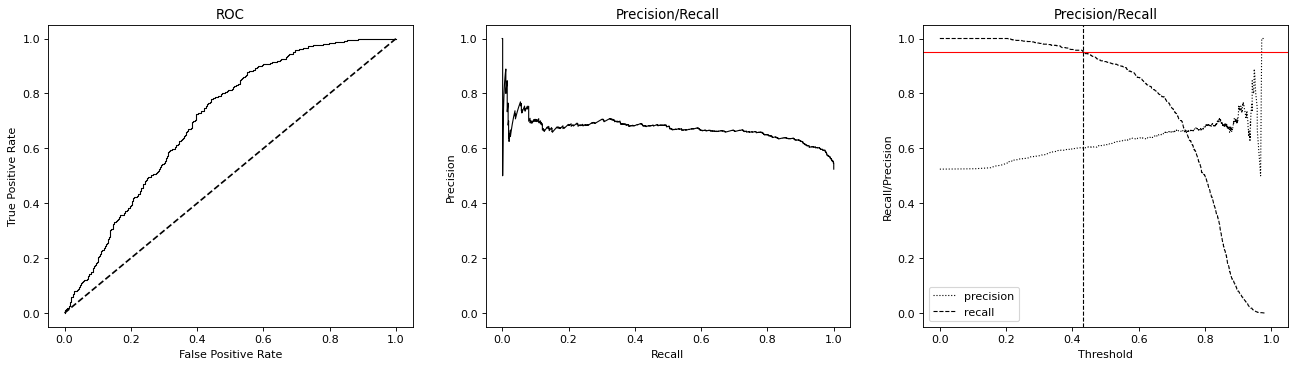

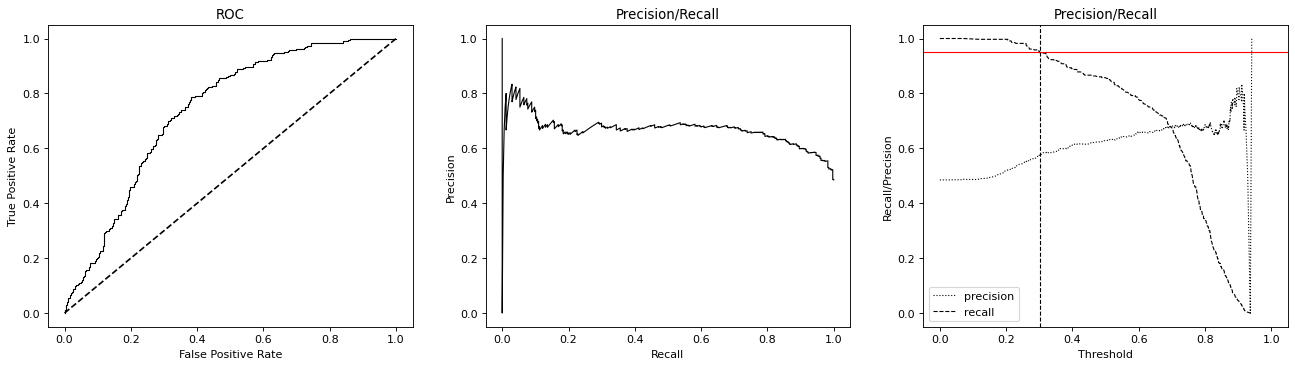

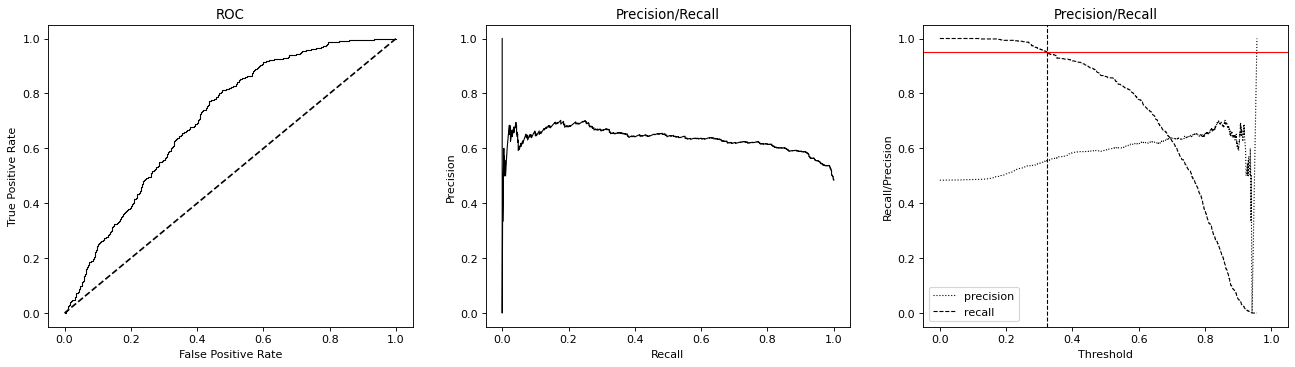

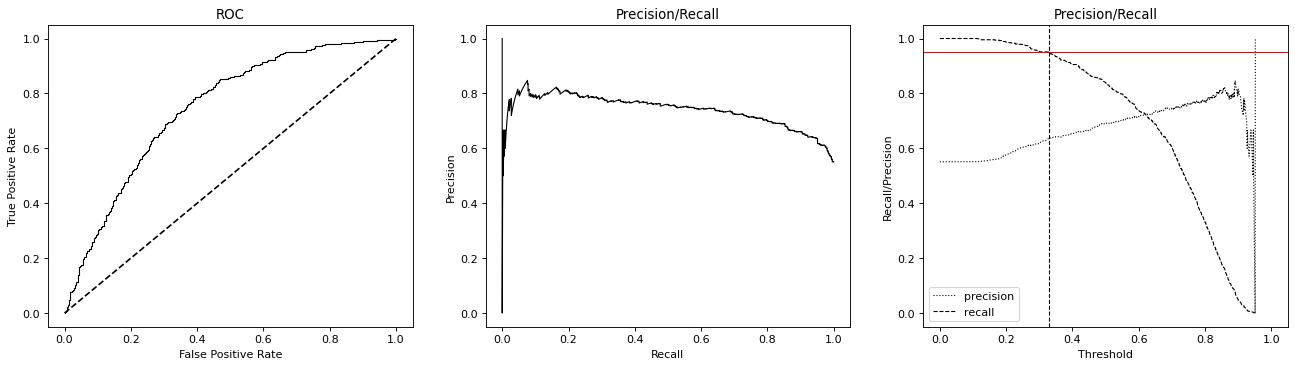

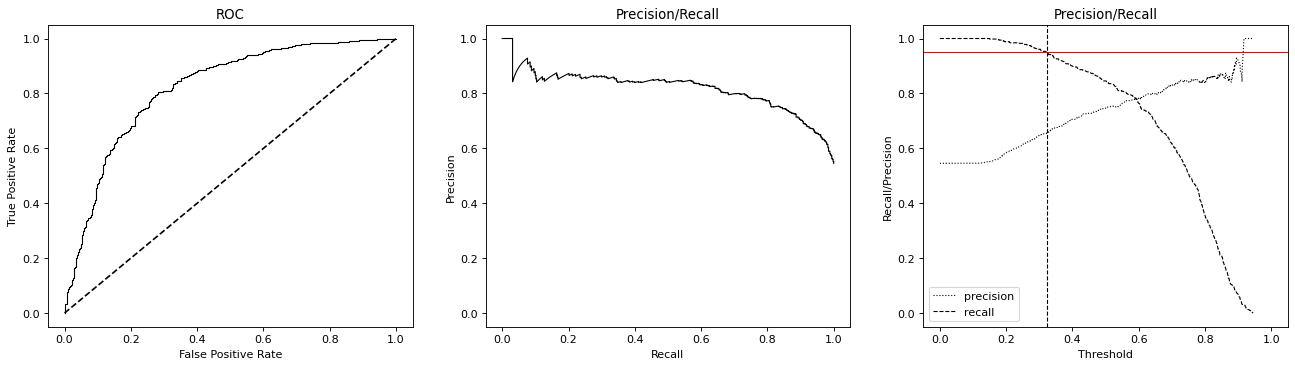

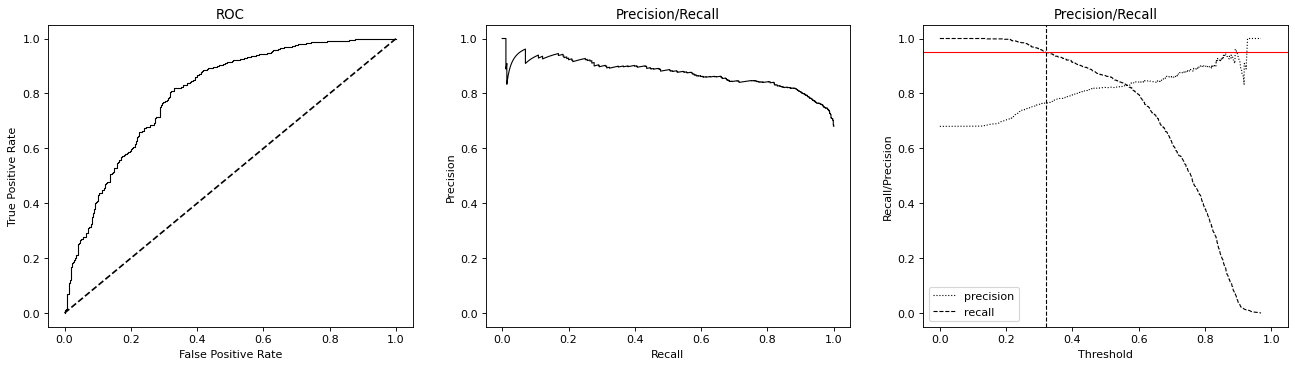

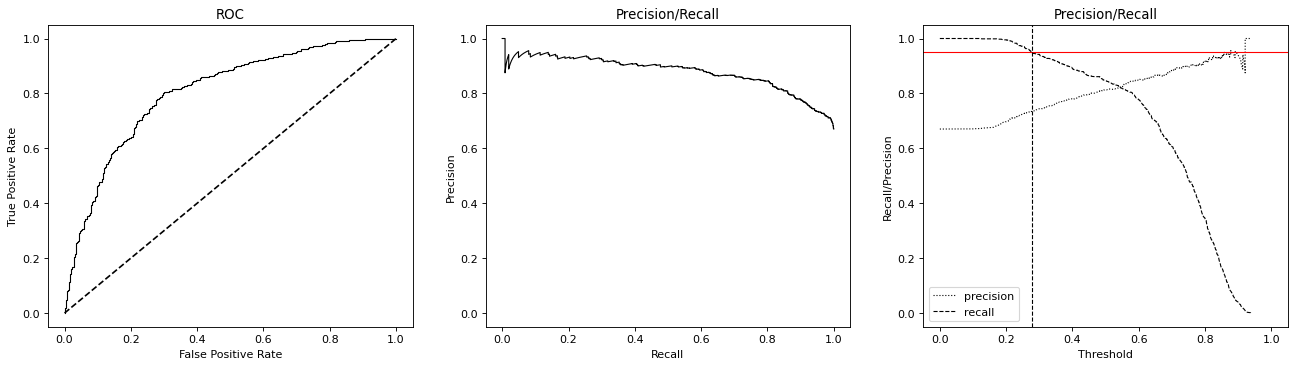

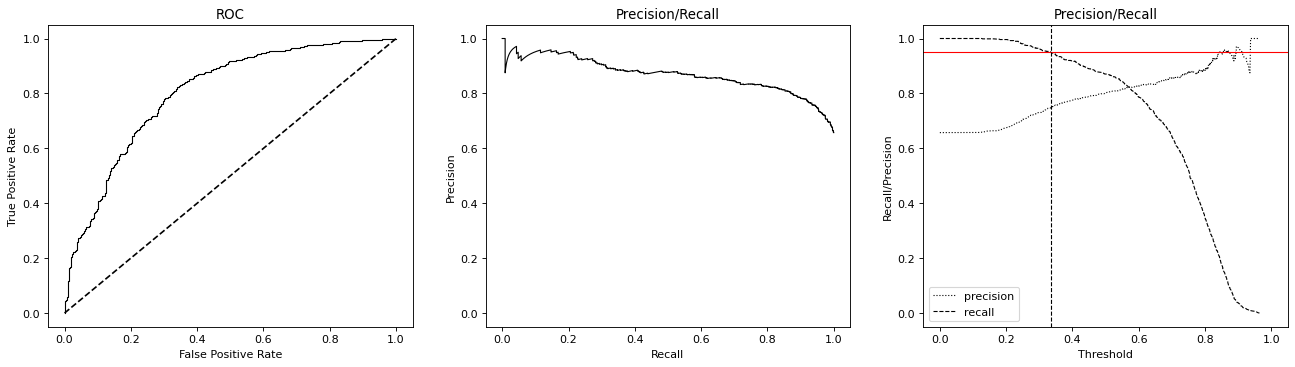

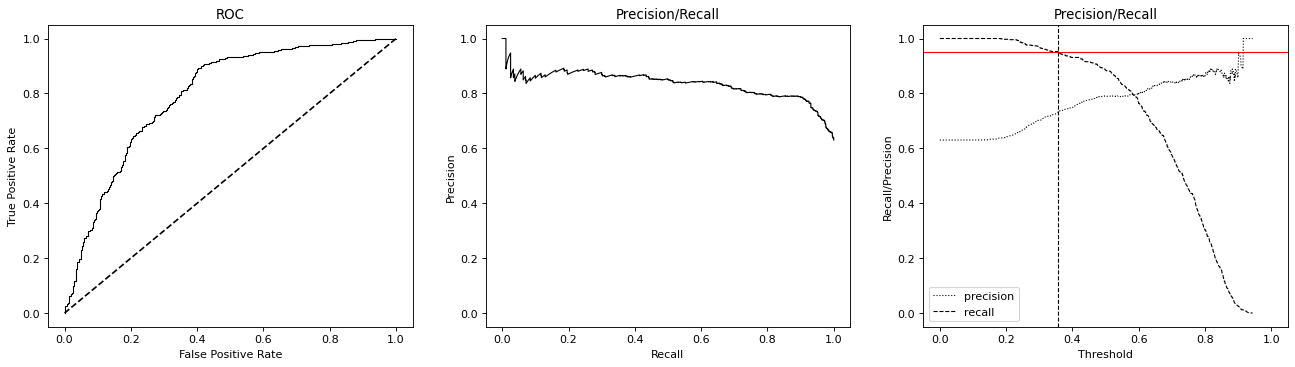

In [200]:
months = [i for i in range(2,12+1)]
queried_invoice_per_month = .05

performance_hist_qbc = []

# query by committee
for month in tqdm(months):
    
    month_data = bags_validation_std_miles[invoice_months == month]
    month_labels = y_round_up_bag_train_2[invoice_months == month]
    
    most_valuable_instances_idx, most_valuable_instances_data = committee.query(month_data, n_instances=int(len(month_data)*queried_invoice_per_month))
    teached_idx = most_valuable_instances_idx.tolist()
    
    committee.teach(most_valuable_instances_data, month_labels[most_valuable_instances_idx])
    
    # Predict on validation set
    y_bag_validation_pred = pd.DataFrame(committee.predict_proba(np.delete(month_data, teached_idx, axis=0)))
    # Evaluate prediction
    min_threshold, specificity, auc = model_evaluation(np.delete(month_labels, teached_idx, axis=0), y_bag_validation_pred)

    performance_hist_qbc += [[min_threshold, specificity, auc]]

In [201]:
performance_hist_qbc_5 = performance_hist_qbc

In [ ]:
raise(Exception('Stop'))

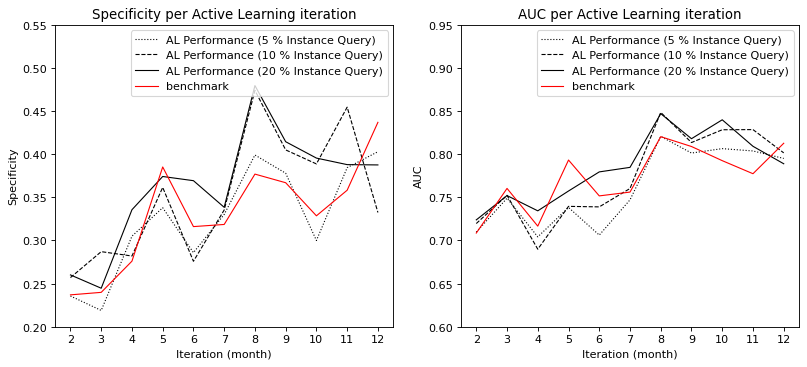

In [202]:
auc_evolution_qbc_5 = [i[2] for i in performance_hist_qbc_5]
auc_evolution_qbc_10 = [i[2] for i in performance_hist_qbc_10]
auc_evolution_qbc_20 = [i[2] for i in performance_hist_qbc_20]
specificity_evolution_qbc_5 = [i[1]/100 for i in performance_hist_qbc_5]
specificity_evolution_qbc_10 = [i[1]/100 for i in performance_hist_qbc_10]
specificity_evolution_qbc_20 = [i[1]/100 for i in performance_hist_qbc_20]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

axs[0].plot(np.arange(2, 13, 1), specificity_evolution_qbc_5, lw=1, color='black', ls='dotted', label='AL Performance (5 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_evolution_qbc_10, lw=1, color='black', ls='dashed', label='AL Performance (10 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_evolution_qbc_20, lw=1, color='black', ls='solid', label='AL Performance (20 % Instance Query)')
axs[0].plot(np.arange(2, 13, 1), specificity_benchmark, lw=1, color='red', label='Benchmark')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[0].legend()

axs[1].plot(np.arange(2, 13, 1), auc_evolution_qbc_5, lw=1, color='black', ls='dotted', label='AL Performance (5 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_evolution_qbc_10, lw=1, color='black', ls='dashed', label='AL Performance (10 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_evolution_qbc_20, lw=1, color='black', ls='solid', label='AL Performance (20 % Instance Query)')
axs[1].plot(np.arange(2, 13, 1), auc_benchmark, lw=1, color='red', label='Benchmark')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration', yticks=np.arange(.6, 1, .05), xticks=np.arange(2, 13, 1))
axs[1].legend()

## Uncertainty - QBC plot

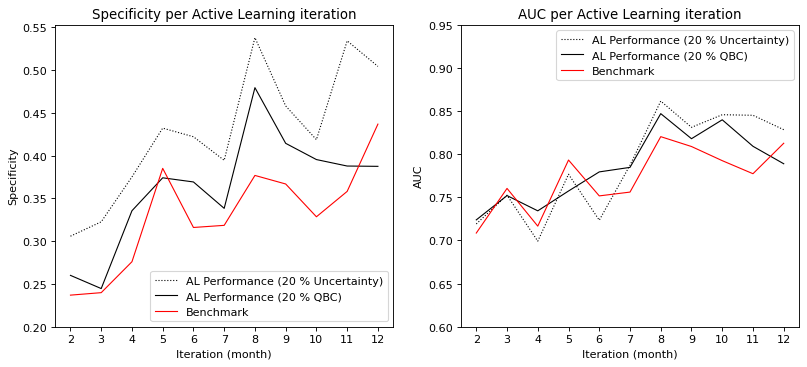

In [209]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

axs[0].plot(np.arange(2, 13, 1), specificity_evolution_uncertainty_20, lw=1, color='black', ls='dotted', label='AL Performance (20 % Uncertainty)')
axs[0].plot(np.arange(2, 13, 1), specificity_evolution_qbc_20, lw=1, color='black', ls='solid', label='AL Performance (20 % QBC)')
axs[0].plot(np.arange(2, 13, 1), specificity_benchmark, lw=1, color='red', label='Benchmark')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration', yticks=np.arange(.2, .6, .05), xticks=np.arange(2, 13, 1))
axs[0].legend()

axs[1].plot(np.arange(2, 13, 1), auc_evolution_uncertainty_20, lw=1, color='black', ls='dotted', label='AL Performance (20 % Uncertainty)')
axs[1].plot(np.arange(2, 13, 1), auc_evolution_qbc_20, lw=1, color='black', ls='solid', label='AL Performance (20 % QBC)')
axs[1].plot(np.arange(2, 13, 1), auc_benchmark, lw=1, color='red', label='Benchmark')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration', yticks=np.arange(.6, 1, .05), xticks=np.arange(2, 13, 1))
axs[1].legend()

## Active Learning - Own attempt

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

10
1467
721


  5%|████▏                                                                              | 1/20 [00:11<03:40, 11.62s/it]

AUC = 0.7982246605742114
Recall of 95.00 % reached on 0.259 threshold. This equals a 37.968  % precision
10
1477
711


 10%|████████▎                                                                          | 2/20 [00:23<03:32, 11.78s/it]

AUC = 0.8011101602244092
Recall of 95.00 % reached on 0.265 threshold. This equals a 37.669  % precision
10
1487
701


 15%|████████████▍                                                                      | 3/20 [00:35<03:18, 11.69s/it]

AUC = 0.8033023483365949
Recall of 95.00 % reached on 0.251 threshold. This equals a 37.260  % precision
10
1497
691


 20%|████████████████▌                                                                  | 4/20 [00:47<03:10, 11.92s/it]

AUC = 0.803548365453966
Recall of 95.00 % reached on 0.244 threshold. This equals a 36.695  % precision
10
1507
681


 25%|████████████████████▊                                                              | 5/20 [00:59<02:58, 11.93s/it]

AUC = 0.8065144525648336
Recall of 95.00 % reached on 0.263 threshold. This equals a 39.548  % precision
10
1517
671


 30%|████████████████████████▉                                                          | 6/20 [01:11<02:47, 11.99s/it]

AUC = 0.8090520694259011
Recall of 95.00 % reached on 0.260 threshold. This equals a 40.286  % precision
10
1527
661


 35%|█████████████████████████████                                                      | 7/20 [01:23<02:35, 11.98s/it]

AUC = 0.8097367455512751
Recall of 95.00 % reached on 0.271 threshold. This equals a 42.899  % precision
10
1537
651


 40%|█████████████████████████████████▏                                                 | 8/20 [01:35<02:24, 12.06s/it]

AUC = 0.8130887081520712
Recall of 95.00 % reached on 0.264 threshold. This equals a 41.765  % precision
10
1547
641


 45%|█████████████████████████████████████▎                                             | 9/20 [01:48<02:15, 12.28s/it]

AUC = 0.8174293300015619
Recall of 95.00 % reached on 0.248 threshold. This equals a 37.389  % precision
10
1557
631


 50%|█████████████████████████████████████████                                         | 10/20 [02:00<02:02, 12.29s/it]

AUC = 0.8155337361530715
Recall of 95.00 % reached on 0.250 threshold. This equals a 38.671  % precision
10
1567
621


 55%|█████████████████████████████████████████████                                     | 11/20 [02:12<01:50, 12.30s/it]

AUC = 0.815945945945946
Recall of 95.00 % reached on 0.255 threshold. This equals a 39.077  % precision
10
1577
611


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:25<01:38, 12.28s/it]

AUC = 0.8221667203781287
Recall of 95.00 % reached on 0.254 threshold. This equals a 39.875  % precision
10
1587
601


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:37<01:26, 12.34s/it]

AUC = 0.8197857697857698
Recall of 95.00 % reached on 0.252 threshold. This equals a 38.730  % precision
10
1597
591


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:50<01:15, 12.54s/it]

AUC = 0.8278535197043769
Recall of 95.00 % reached on 0.244 threshold. This equals a 40.129  % precision
10
1607
581


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:03<01:03, 12.67s/it]

AUC = 0.8293444452358906
Recall of 95.00 % reached on 0.245 threshold. This equals a 42.574  % precision
10
1617
571


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:16<00:50, 12.67s/it]

AUC = 0.8320921243752923
Recall of 95.00 % reached on 0.237 threshold. This equals a 41.391  % precision
10
1627
561


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:28<00:37, 12.63s/it]

AUC = 0.8371861858034917
Recall of 95.00 % reached on 0.246 threshold. This equals a 43.729  % precision
10
1637
551


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:42<00:25, 12.79s/it]

AUC = 0.8371200105736188
Recall of 95.00 % reached on 0.245 threshold. This equals a 44.330  % precision
10
1647
541


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:55<00:12, 12.89s/it]

AUC = 0.8437139561707035
Recall of 95.00 % reached on 0.235 threshold. This equals a 41.869  % precision
10
1657
531


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.42s/it]

AUC = 0.8495004995004994
Recall of 95.00 % reached on 0.255 threshold. This equals a 46.154  % precision


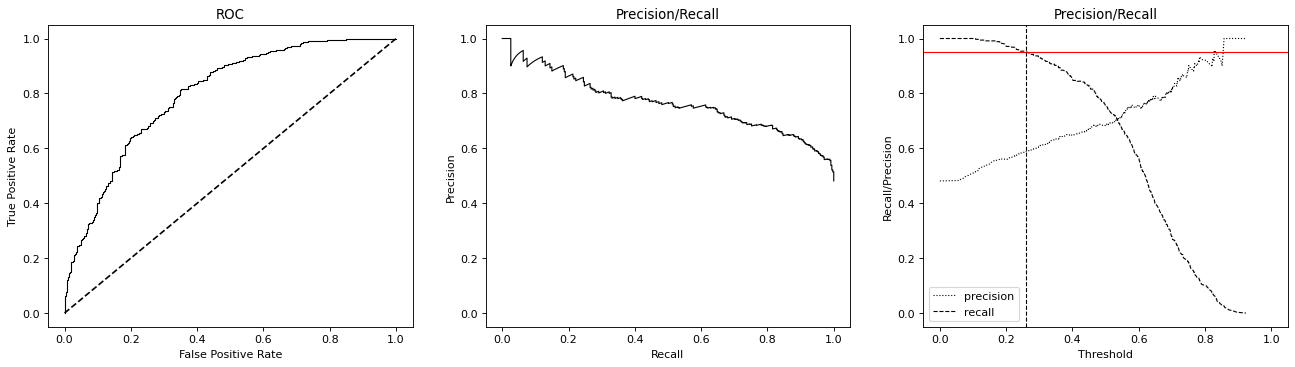

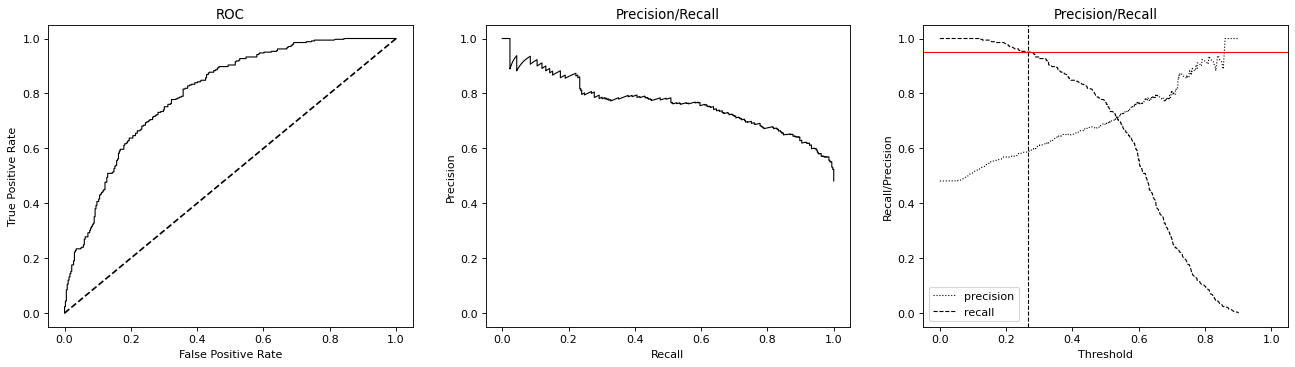

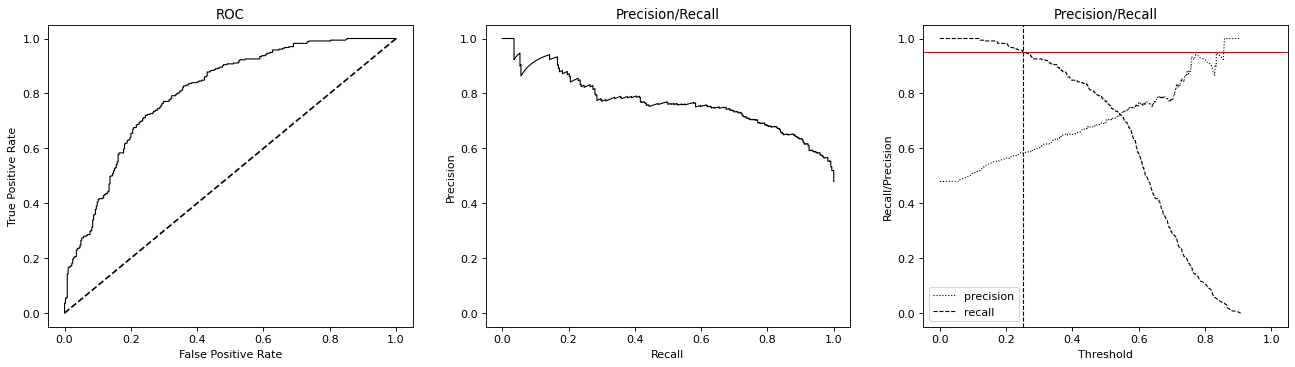

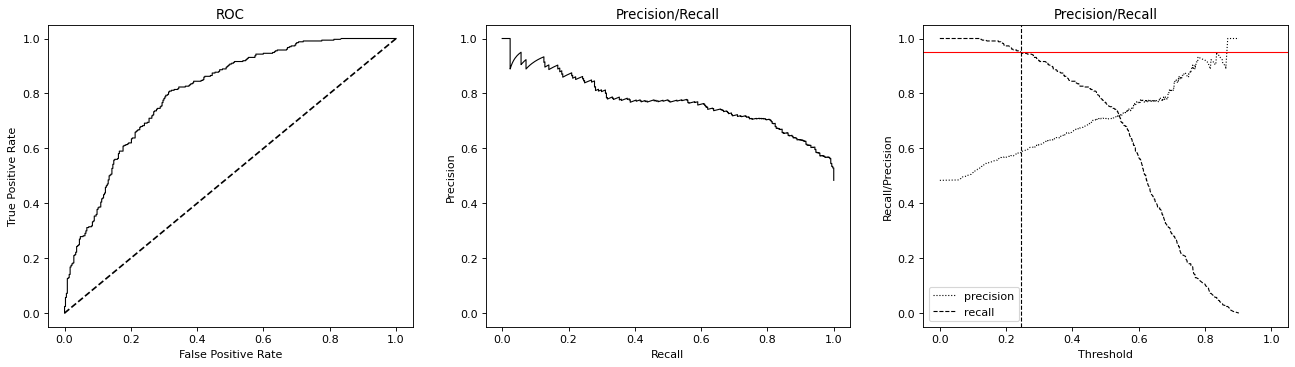

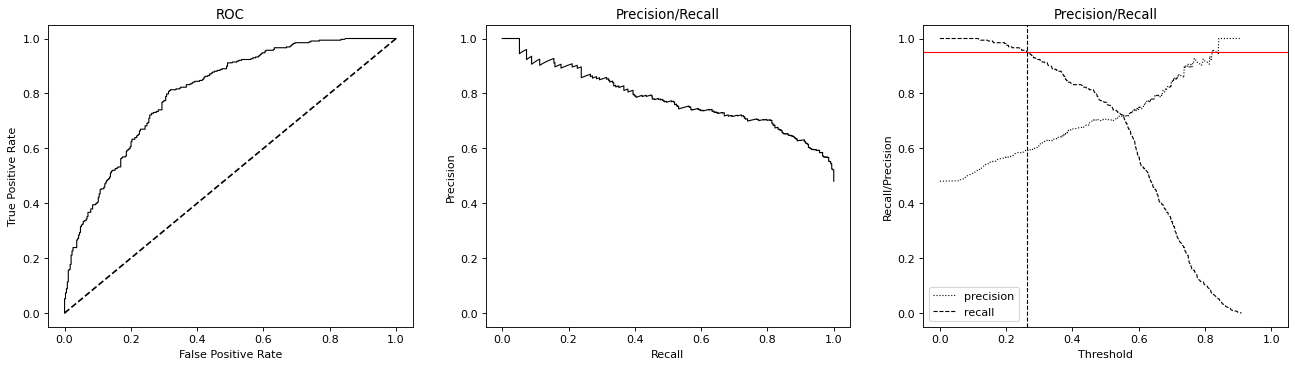

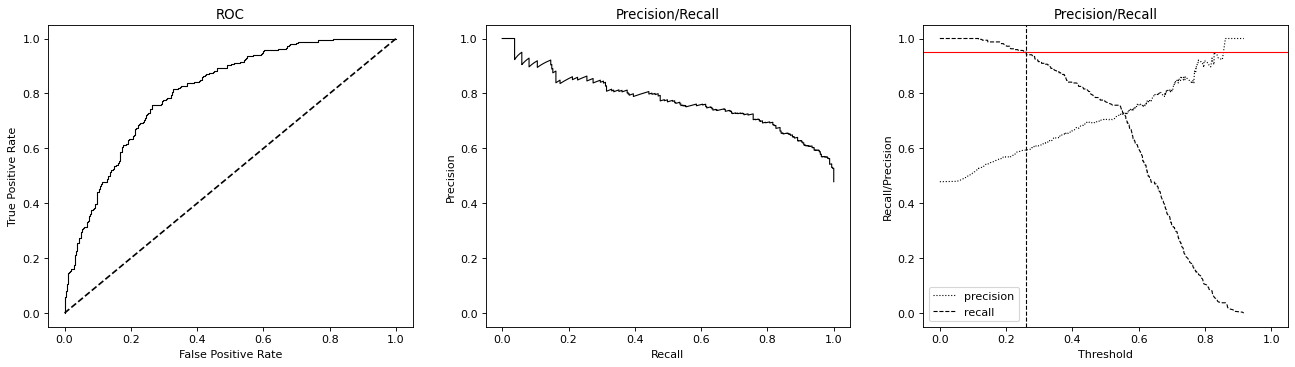

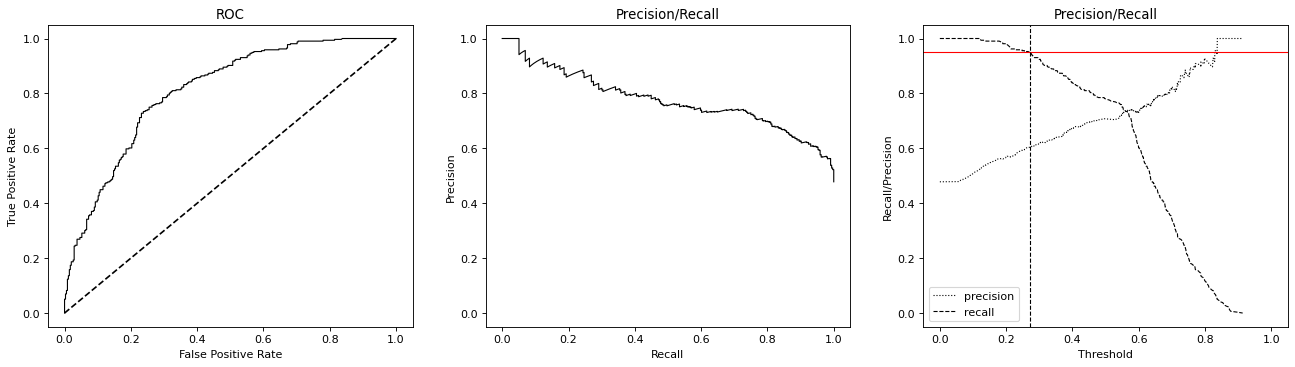

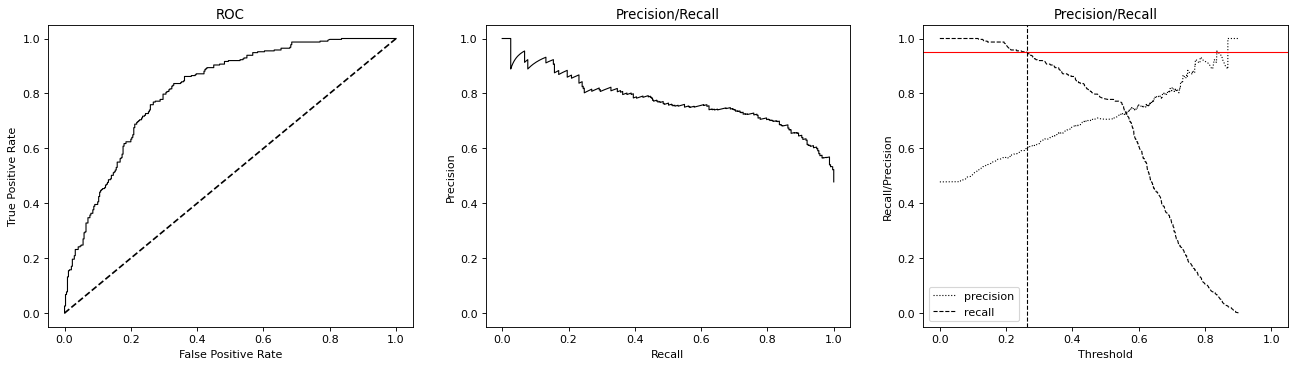

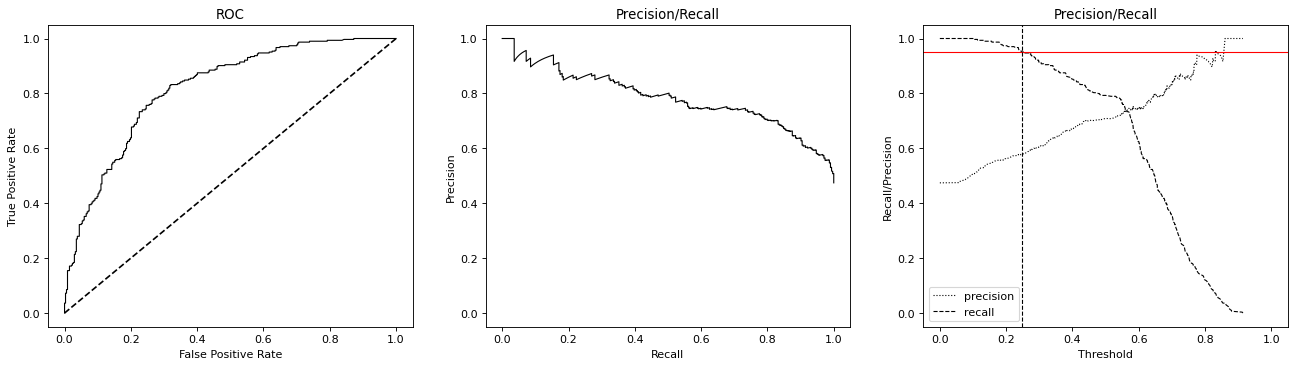

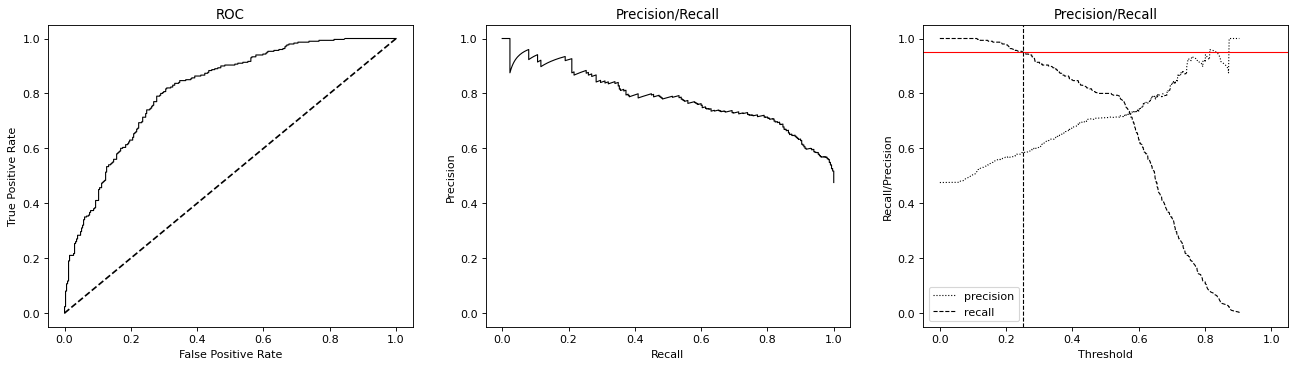

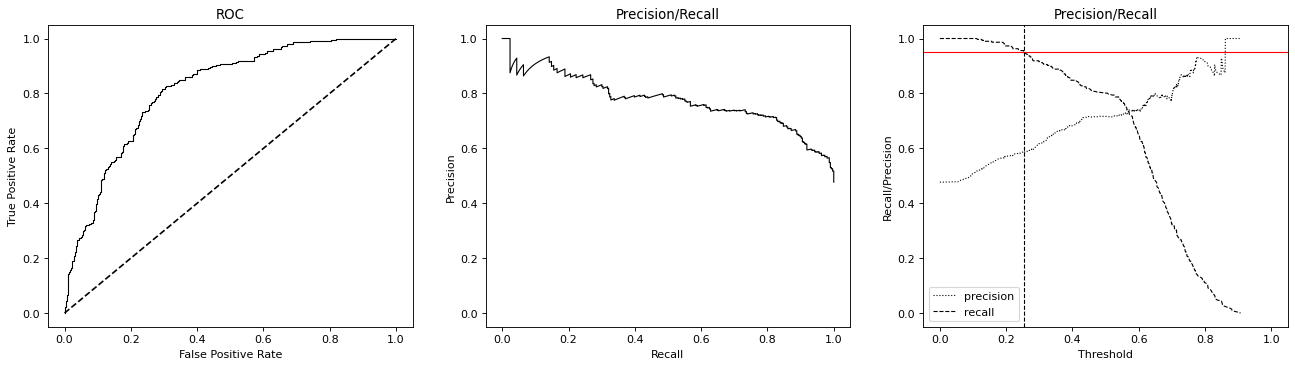

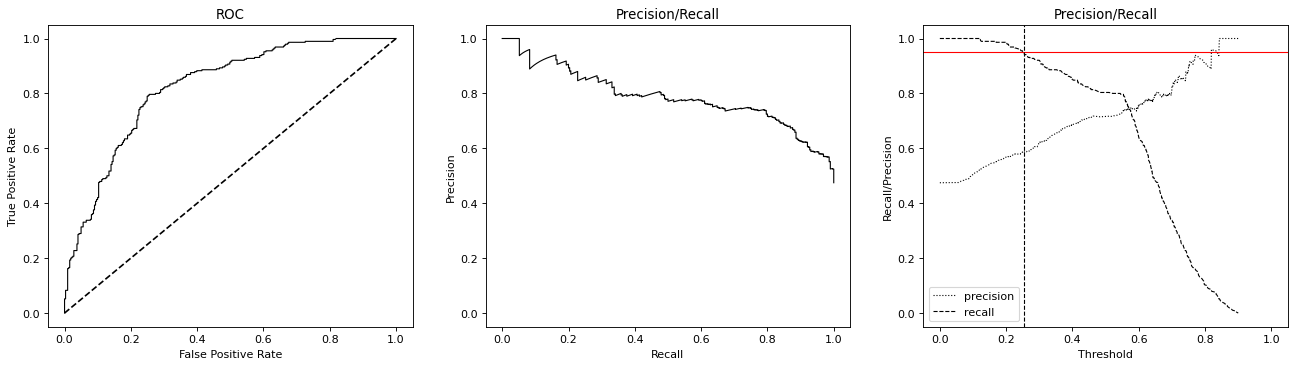

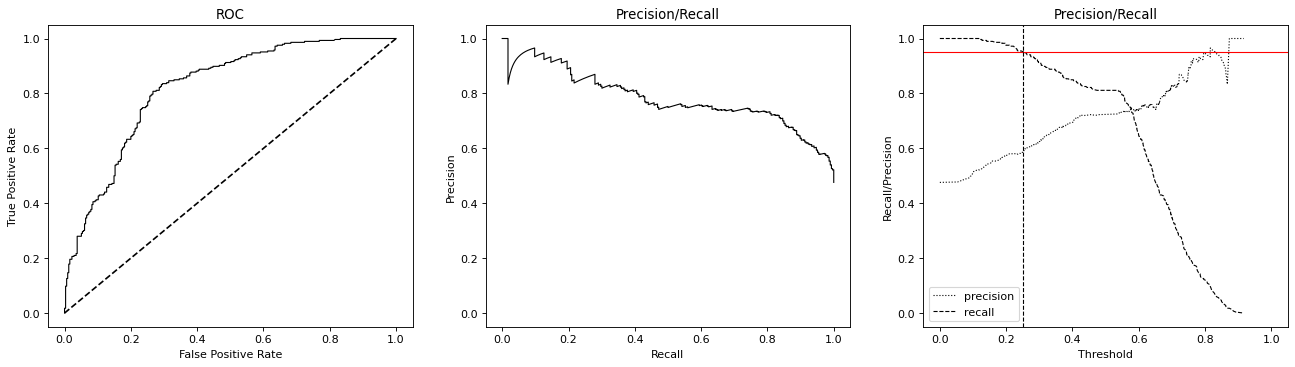

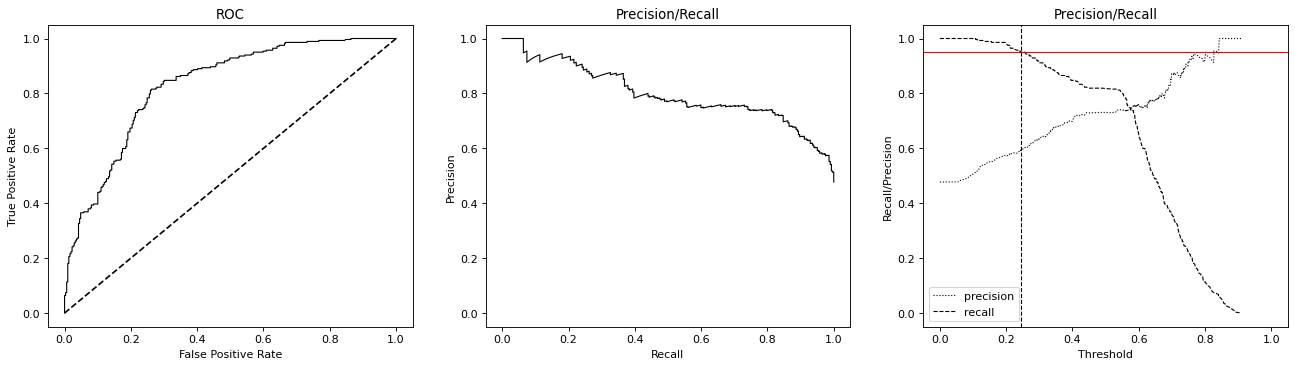

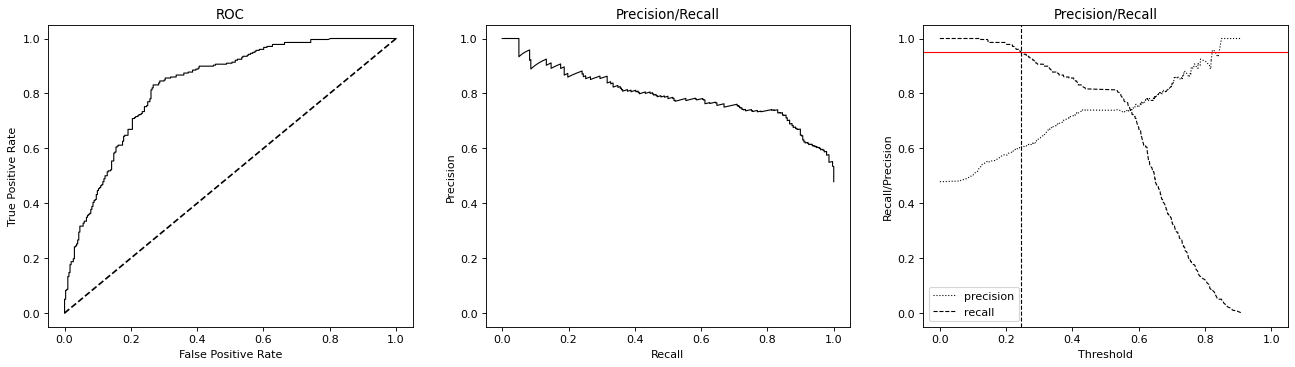

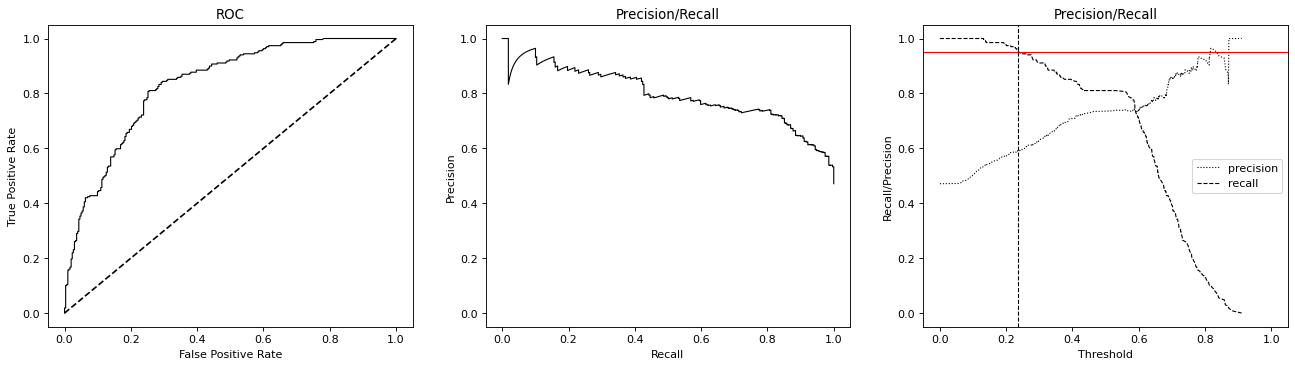

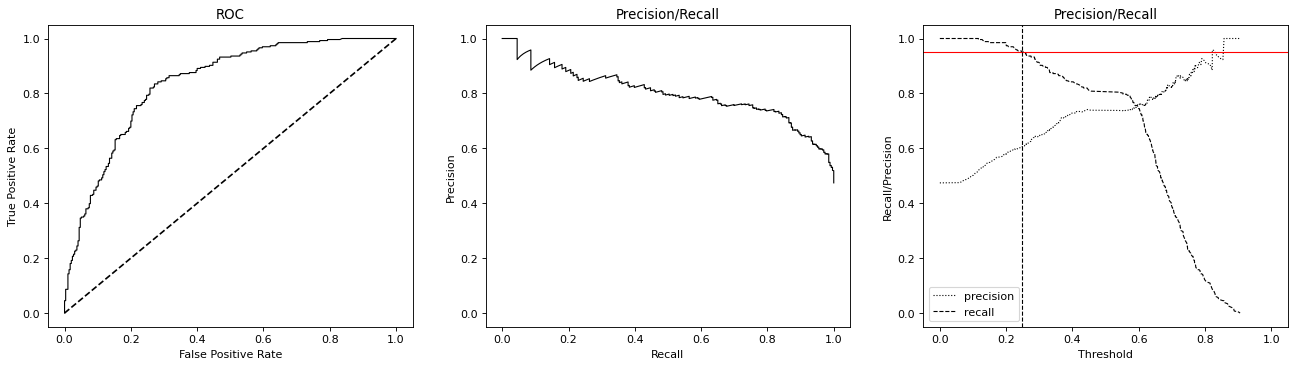

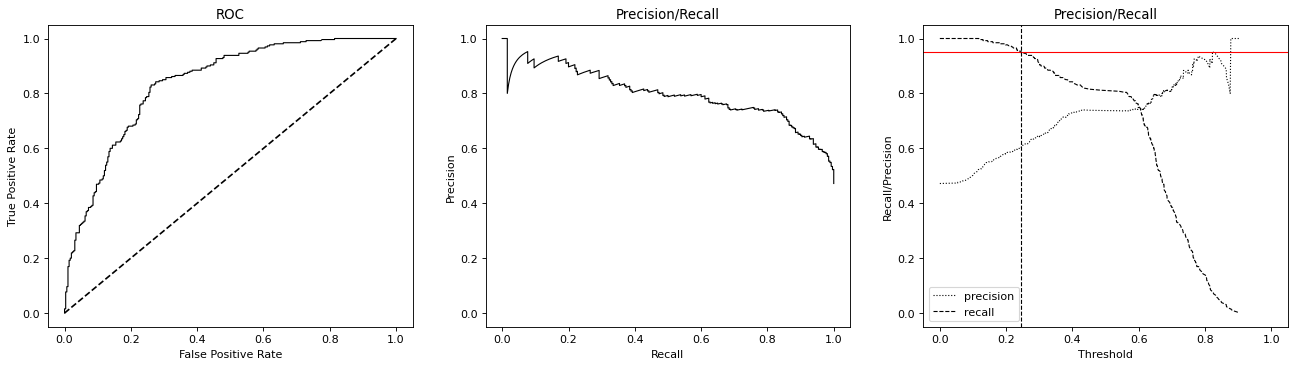

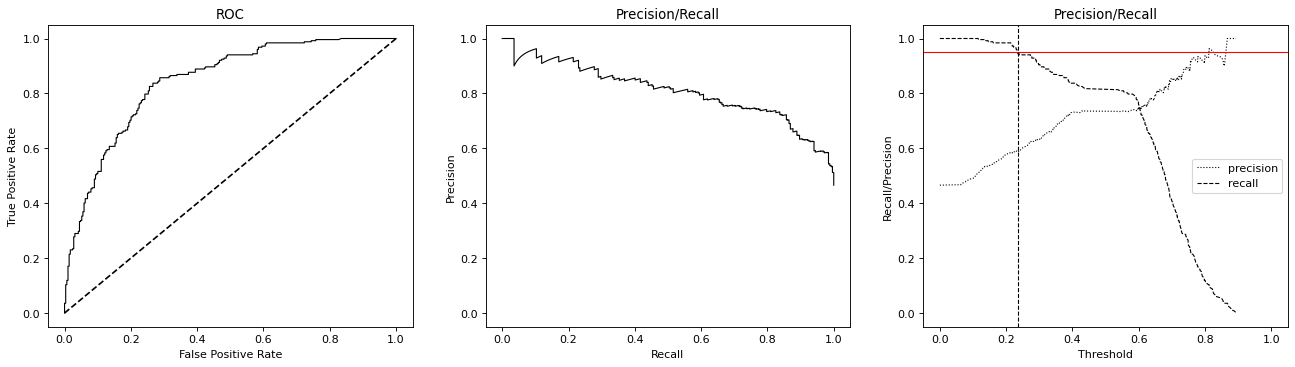

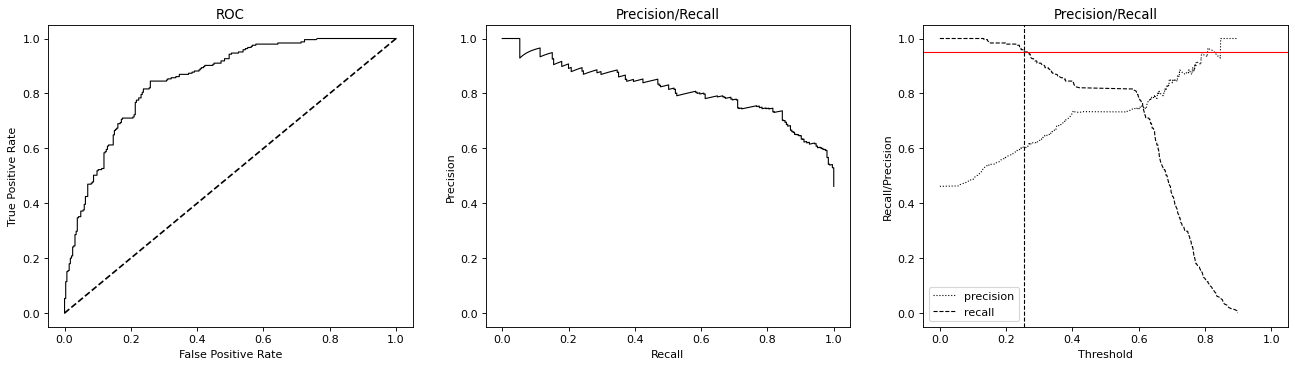

In [27]:
moved_invoices = 200
step_size = 10

scores = []

for i in tqdm(range(0, int(moved_invoices/step_size))):
    
    y_bag_validation_pred['uncertainty'] = 1-(y_bag_validation_pred[1]-.5).abs()
    uncertain_instances = y_bag_validation_pred.sort_values(by='uncertainty', ascending=False).index[:step_size]
    
    # Move uncertain training instances
    bags_train_std_miles = np.append(bags_train_std_miles, bags_validation_std_miles[uncertain_instances], axis=0)
    bags_validation_std_miles = np.delete(bags_validation_std_miles, uncertain_instances, axis=0)
    y_round_up_bag_train_1 = np.append(y_round_up_bag_train_1, y_round_up_bag_train_2[uncertain_instances], axis=0)
    y_round_up_bag_train_2 = np.delete(y_round_up_bag_train_2, uncertain_instances, axis=0)
    
    # Retrain
    rf.fit(X=bags_train_std_miles, y=y_round_up_bag_train_1)
    
    # Reevaluate
    y_bag_validation_pred = pd.DataFrame(rf.predict_proba(bags_validation_std_miles))
    min_threshold, specificity, auc = model_evaluation(y_round_up_bag_train_2, y_bag_validation_pred)
    
    scores += [[min_threshold, specificity]]

In [29]:
scores

[[0.258991236549314, 37.967914438502675],
 [0.265105055987706, 37.669376693766935],
 [0.25103620313593017, 37.26027397260274],
 [0.2437027540045468, 36.69467787114846],
 [0.26299730720633274, 39.548022598870055],
 [0.2597020983852545, 40.285714285714285],
 [0.27071052331231227, 42.89855072463768],
 [0.2639747838836049, 41.76470588235294],
 [0.24774565730638945, 37.388724035608305],
 [0.25030418213338707, 38.670694864048336],
 [0.2549980738930911, 39.07692307692307],
 [0.25444325490554126, 39.875389408099686],
 [0.2516568985423431, 38.730158730158735],
 [0.24390163710330925, 40.1294498381877],
 [0.24470438166746272, 42.57425742574257],
 [0.23676843732715838, 41.390728476821195],
 [0.24630473962997113, 43.728813559322035],
 [0.24538918206074523, 44.329896907216494],
 [0.2346223104043132, 41.86851211072664],
 [0.2548787105732295, 46.15384615384615]]

In [28]:
pd.DataFrame(confusion_matrix(y_round_up_bag_train_2, y_bag_validation_pred.iloc[:, 1]>min_threshold), columns=['PRED_FALSE', 'PRED_TRUE'], index=['ACTUAL_FALSE', 'ACTUAL_TRUE'])

,PRED_FALSE,PRED_TRUE
ACTUAL_FALSE,132,154
ACTUAL_TRUE,12,233


In [ ]:
raise(Exception('Stop'))

# Admin queries

In [ ]:
from admin import admin_sql

cnxn_admin_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')

df = cnxn_admin_sql.sql_query('''
                                SELECT i.INVOICE_NR, i.INVOICE_DATE, ild.*
                                FROM DBA.INVOICE i
                                LEFT JOIN DBA.INVOICE_LINES ild ON i.INVOICE_ID = ild.INVOICE_ID
                                WHERE i.INVOICE_ID = '589271' ''')
df.head()

In [ ]:
589271

# Search CustomerId via InvoiceNR

In [ ]:
from admin import admin_sql
invoice_nr = 2207804
print('Invoice nr = {}'.format(invoice_nr))
cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(invoice_nr))['CUSTOMER_ID'].iloc[0]))